In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from bokeh.plotting import figure
from bokeh.io import output_notebook,show, export_svgs
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource,ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6,Spectral5,Spectral11,Viridis3, Viridis256

from data_process import pca_scatter
from data_process import coord_transf, affine_transform
from data_process import binning_data,calculate_centroids  

from sklearn.linear_model import LogisticRegression

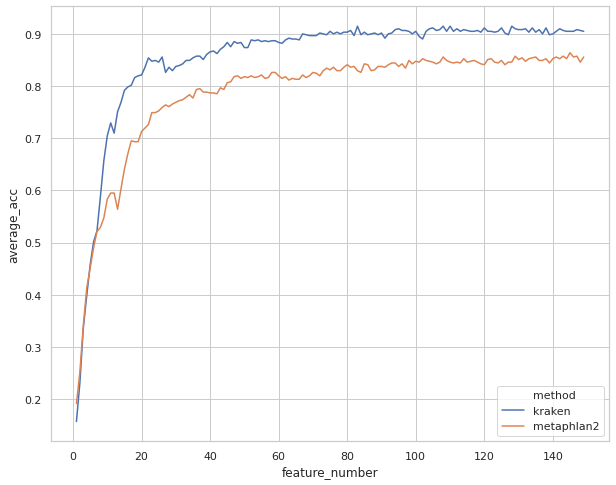

In [2]:
feature_kraken = pd.read_table('../feature_extration_result/feature_extration_result_kraken_data.txt',header=None).rename(columns={0:'feature_number',1:'average_acc',2:'min_acc'})
feature_metaphlan = pd.read_table('../feature_extration_result/feature_extration_result_metaphlan2_data.txt',header=None).rename(columns={0:'feature_number',1:'average_acc',2:'min_acc'})

feature_kraken['method'] = 'kraken'
feature_metaphlan['method'] = 'metaphlan2'
feature_n = pd.concat([feature_kraken,feature_metaphlan])

plt.figure(figsize=(10,8))
sns.set(style="whitegrid")
sns.lineplot(x='feature_number',y='average_acc',hue='method',data=feature_n)
plt.savefig('../img/feature_number.pdf',dpi=300)

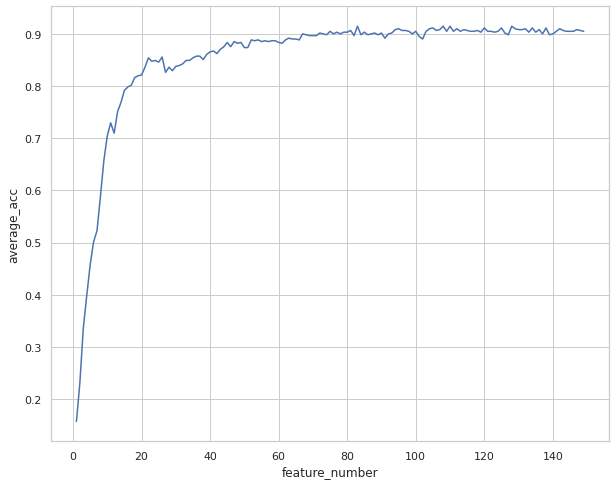

In [3]:
plt.figure(figsize=(10,8))
sns.set(style="whitegrid")
sns.lineplot(x='feature_number',y='average_acc',data=feature_n[feature_n.method=='kraken'])
plt.savefig('../img/kraken_feature_number.pdf',dpi=300)

Fig. 3. Prediction performance on validation set v.s. number of features used for training on the corresponding
training data. Prediction performance is measured by averaging the prediction accuracy over 1000 random
shuffle-splits of training and validation sets on the training dataset provided by the Challenge.

## shuffle result

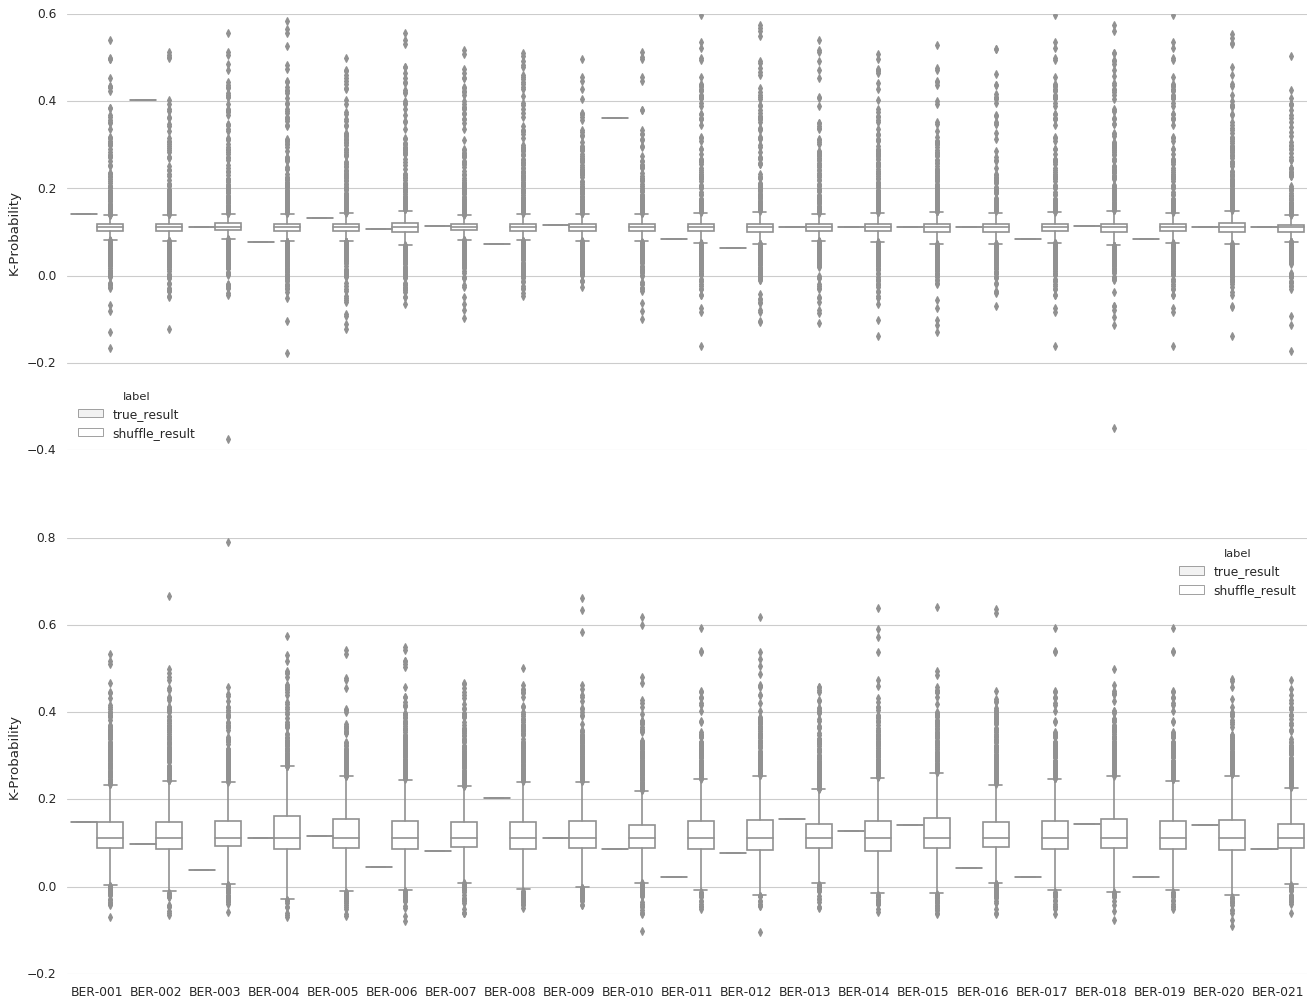

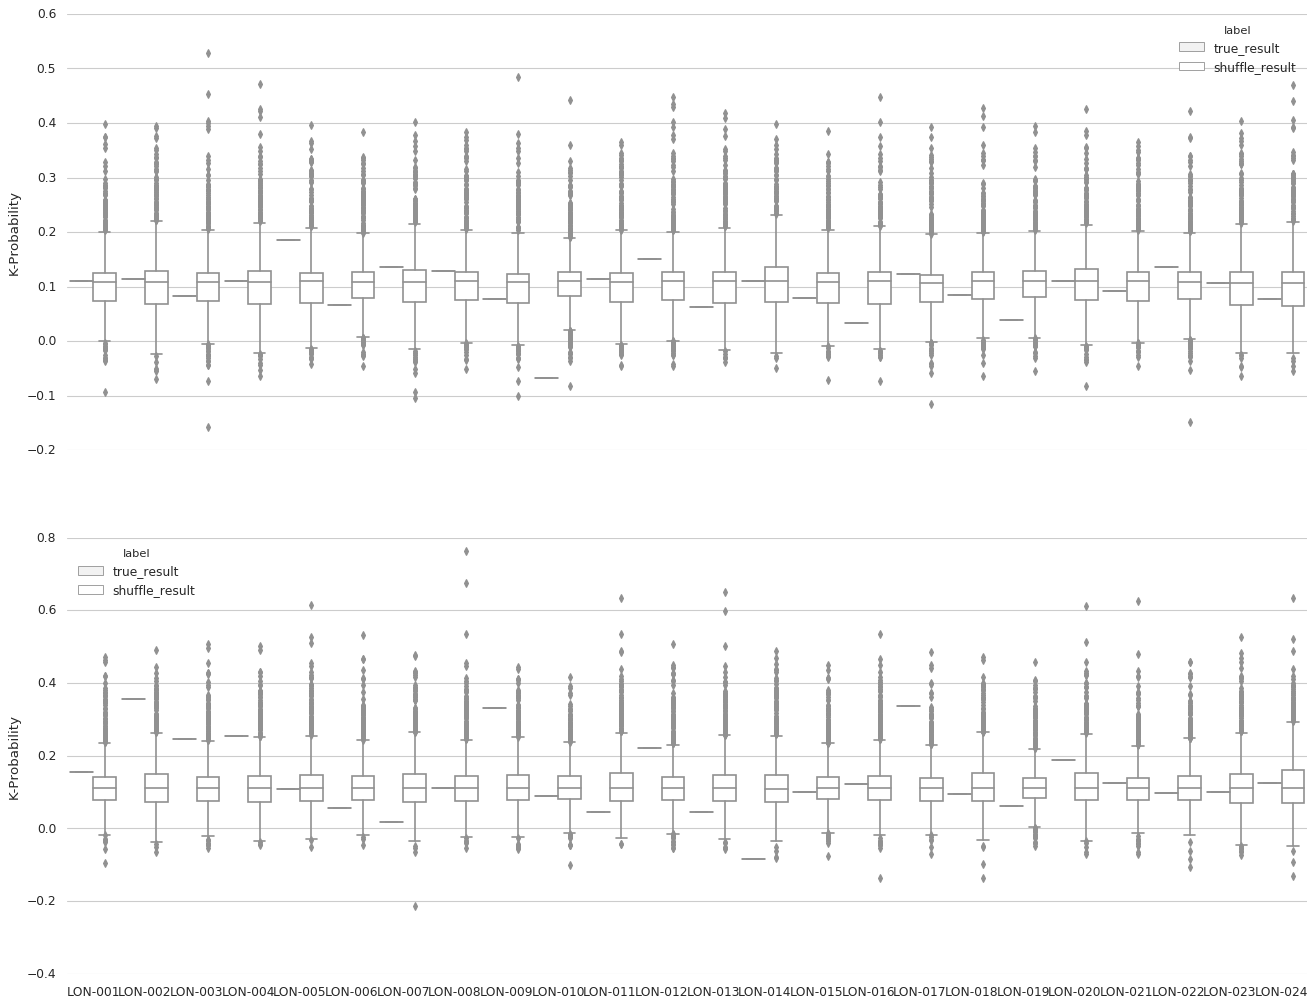

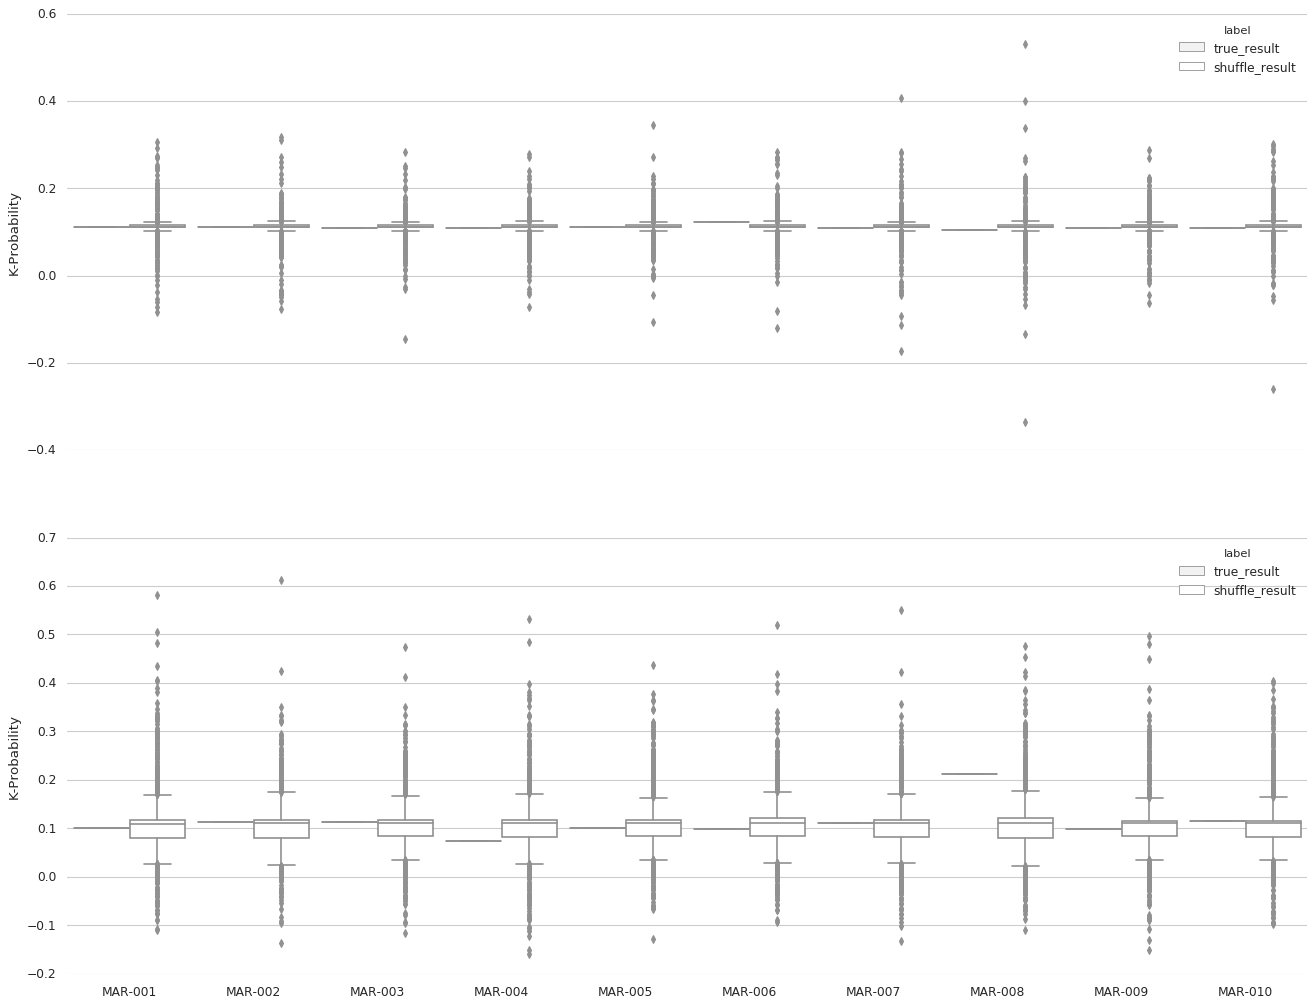

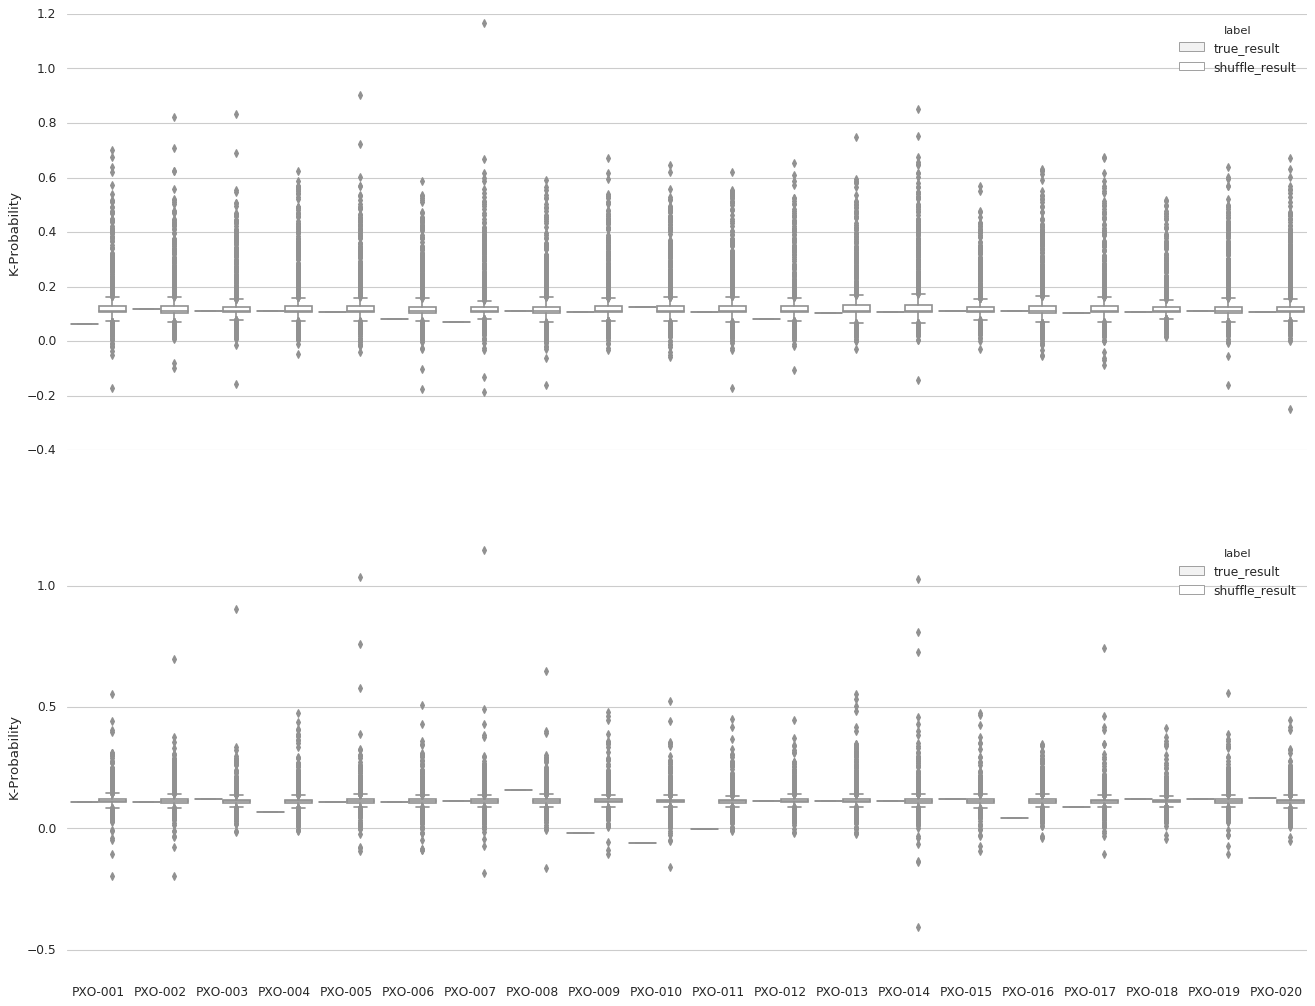

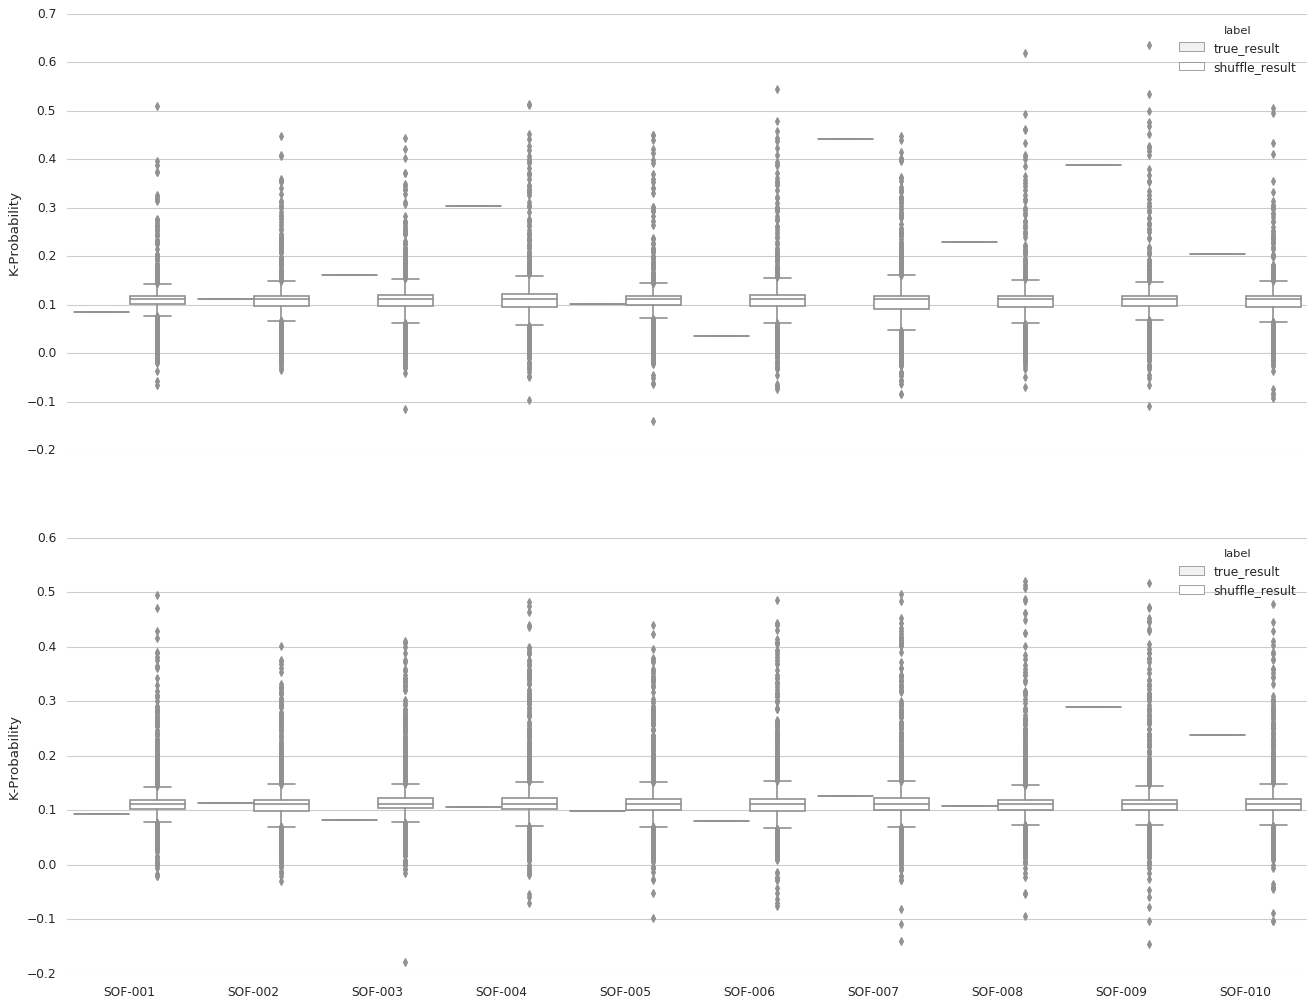

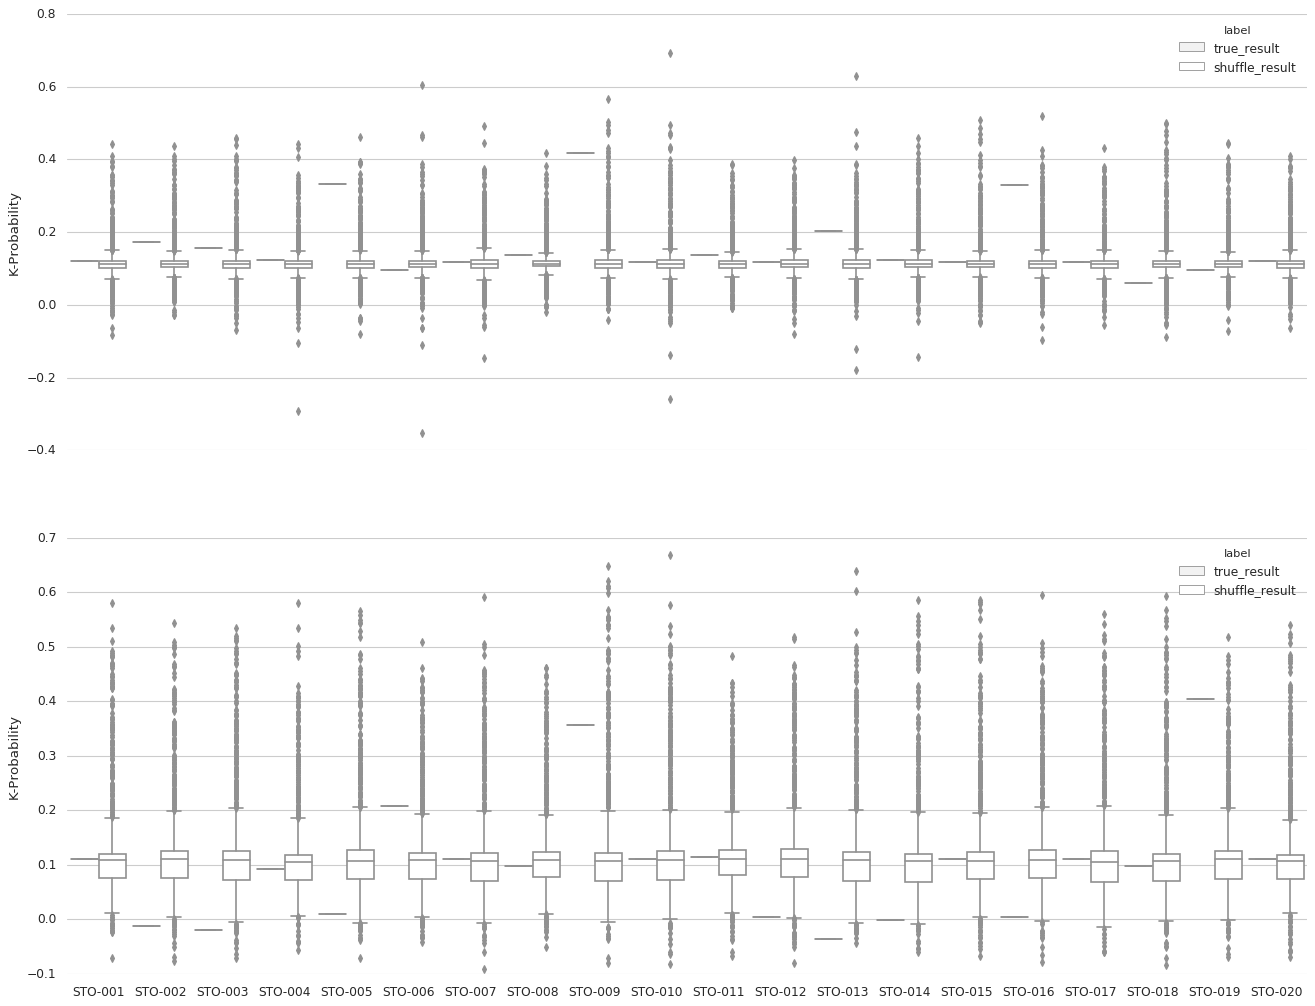

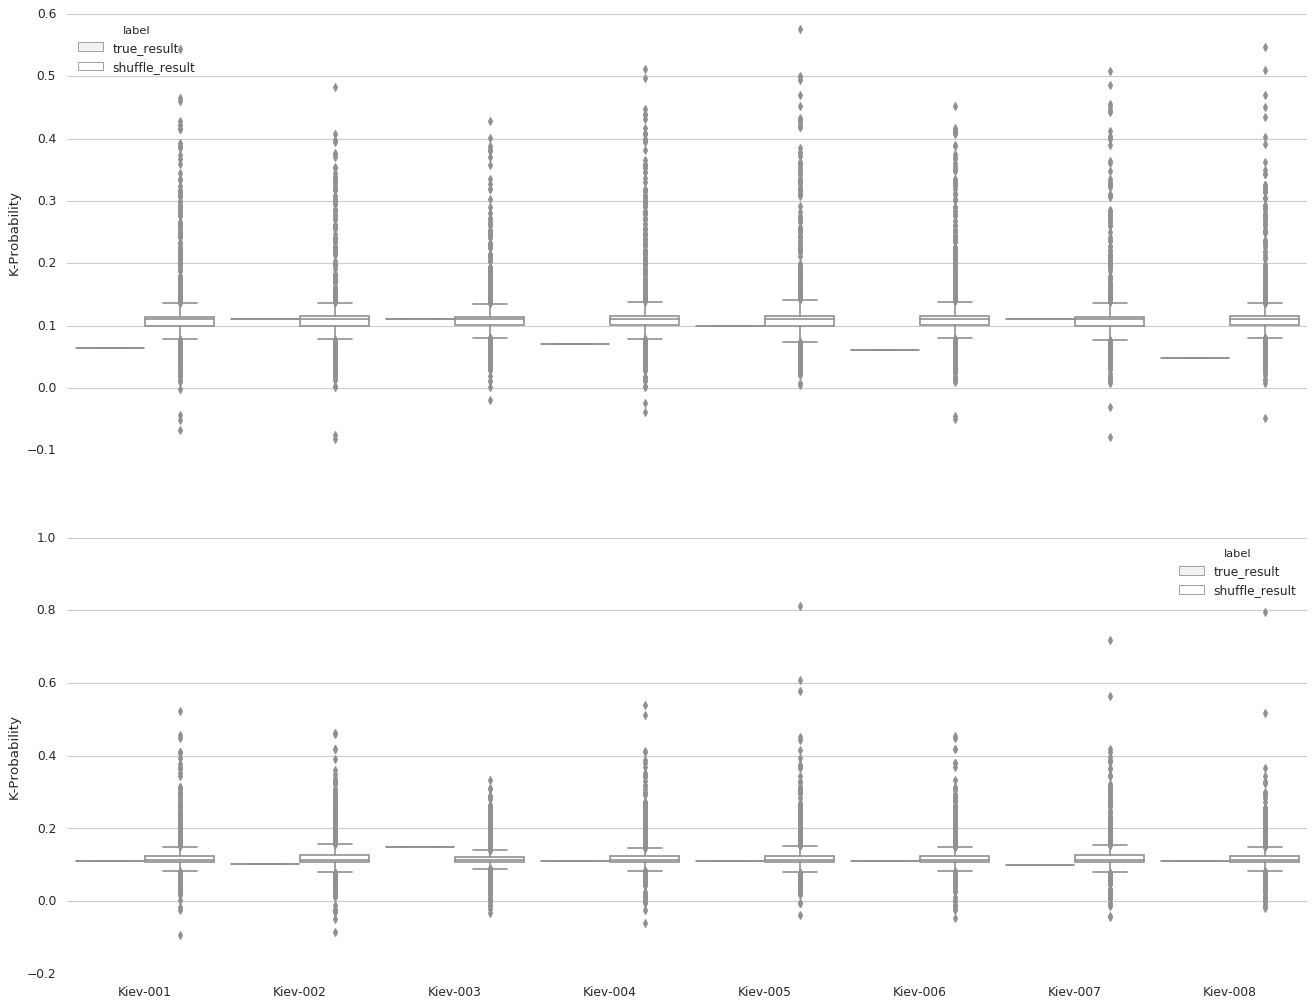

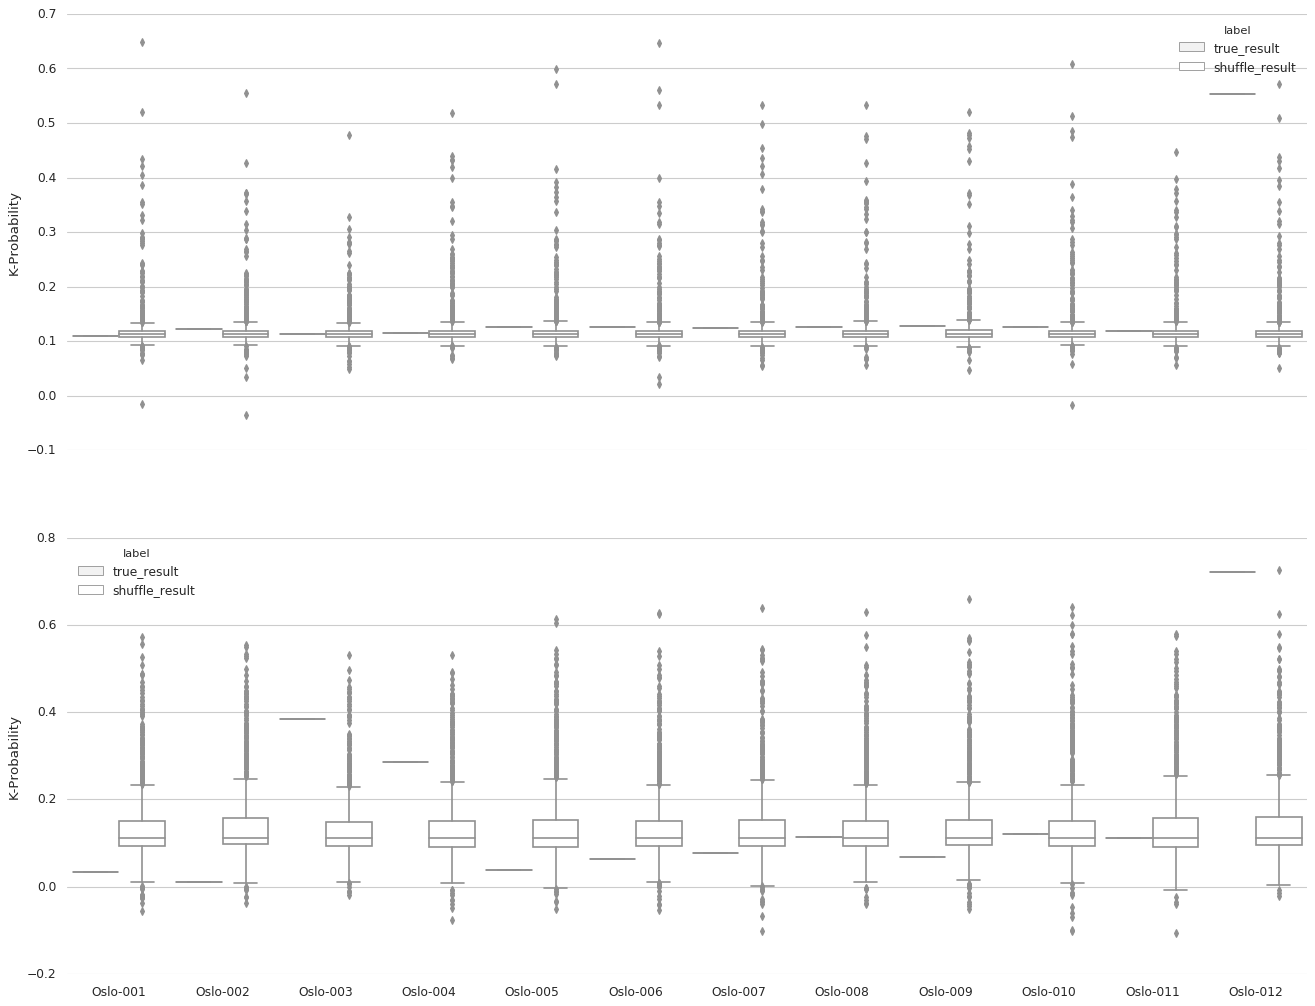

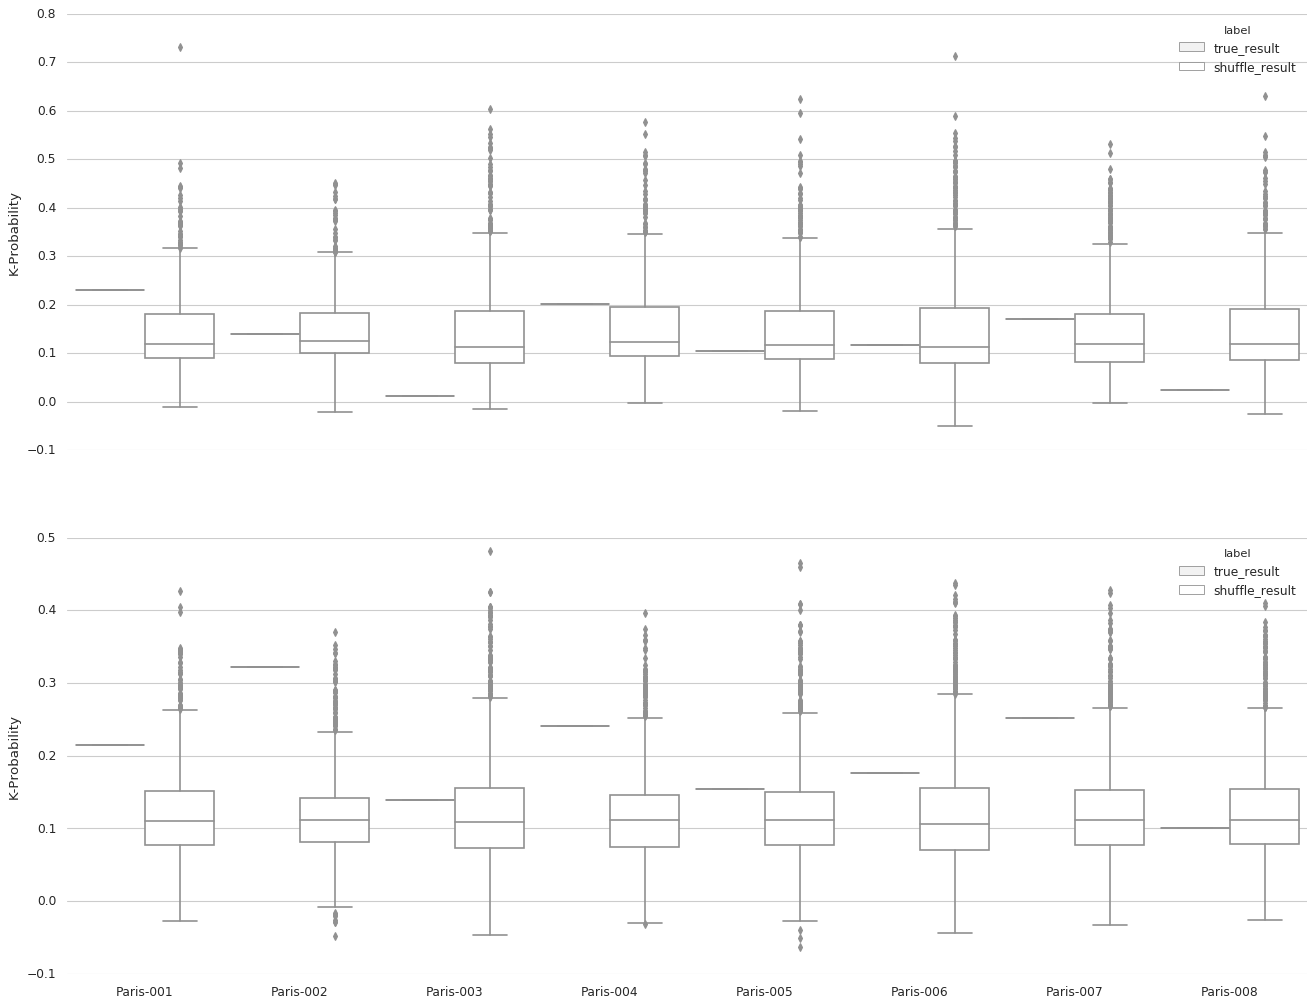

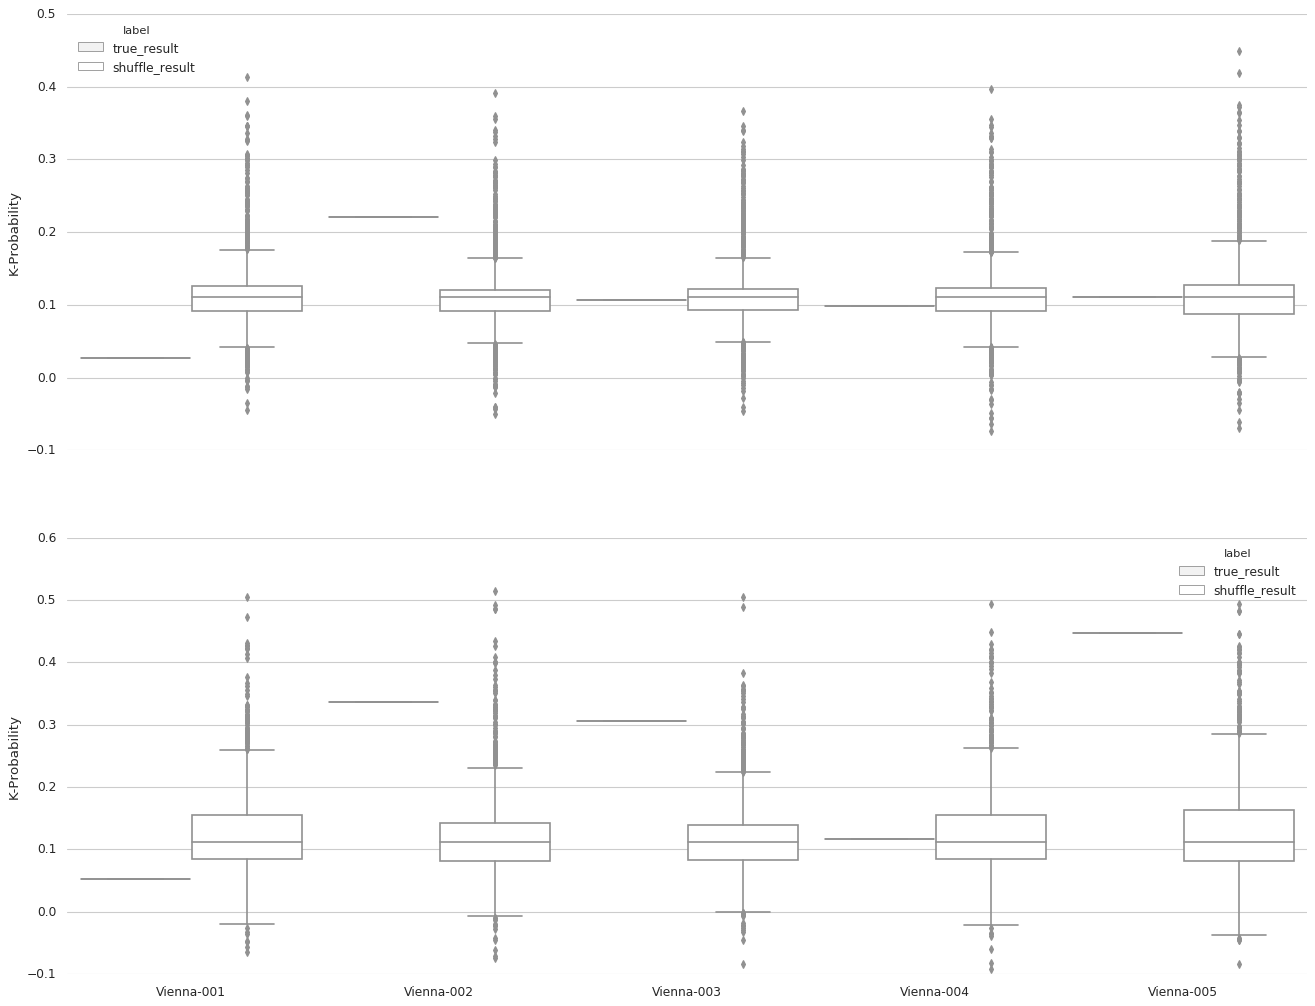

In [422]:
#for i in ['BER','LON','MAR','PXO','SOF','STO','Kiev', 'Oslo', 'Paris', 'Vienna']:
 
#print(i)
tag = 'kraken_data'

for i in ['BER','LON','MAR','PXO','SOF','STO','Kiev', 'Oslo', 'Paris', 'Vienna']:
    city_id = i

    f, (ax1, ax2) = plt.subplots(2, 1, sharex='all',figsize=(20,15))
    with open('../random_test/{}/bio_shuffle_{}_result.txt'.format(tag,city_id),'r') as f:
        shuffle_result = np.array([eval(i) for i in f.read().split('\n') if i])

    with open('../random_test/{}/bio_true_{}_result.txt'.format(tag,city_id),'r') as f:
        true_result = np.array([eval(i) for i in f.read().split('\n')[:1] if i])
    shuffle_result = pd.DataFrame(columns=[['{}-00{}'.format(city_id,i+1),'{}-0{}'.format(city_id,i+1)][i+1>=10] for i in range(shuffle_result.shape[1])],data=shuffle_result)
    shuffle_result['label'] = ['shuffle_result']*shuffle_result.shape[0]
    true_result = pd.DataFrame(columns=[['{}-00{}'.format(city_id,i+1),'{}-0{}'.format(city_id,i+1)][i+1>=10] for i in range(true_result.shape[1])],data=true_result)
    true_result['label'] = ['true_result']*true_result.shape[0]
    data = pd.concat([true_result,shuffle_result])
    sns.set(style="whitegrid")
    sns.despine(bottom=True, left=True)
    ax = sns.boxplot(x='variable',
                  y='value',
                  hue='label',
                  ax=ax1,
                  color='white', 
                  width=.9,
                  #split=True,
                  #inner="quart",
                  data=pd.melt(data,id_vars='label'))

    ax.set_xlabel('')
    ax.set_ylabel('K-Probability')
    #for i in ['BER','LON','MAR','PXO','SOF','STO','Kiev', 'Oslo', 'Paris', 'Vienna']:
    bio_result = data    
    #print(i)
    with open('../random_test/{}/geo_shuffle_{}_result.txt'.format(tag,city_id),'r') as f:
        shuffle_result = np.array([eval(i) for i in f.read().split('\n') if i])

    with open('../random_test/{}/geo_true_{}_result.txt'.format(tag,city_id),'r') as f:
        true_result = np.array([eval(i) for i in f.read().split('\n')[:1] if i])
    shuffle_result = pd.DataFrame(columns=[['{}-00{}'.format(city_id,i+1),'{}-0{}'.format(city_id,i+1)][i+1>=10] for i in range(shuffle_result.shape[1])],data=shuffle_result)
    shuffle_result['label'] = ['shuffle_result']*shuffle_result.shape[0]
    true_result = pd.DataFrame(columns=[['{}-00{}'.format(city_id,i+1),'{}-0{}'.format(city_id,i+1)][i+1>=10] for i in range(true_result.shape[1])],data=true_result)
    true_result['label'] = ['true_result']*true_result.shape[0]
    data = pd.concat([true_result,shuffle_result])
    sns.set(style="whitegrid")
    sns.despine(bottom=True, left=True)
    ax = sns.boxplot(x='variable',
                      y='value',
                      hue='label',
                      ax=ax2,
                      color='white', 
                      width=.9,
                      #color='blue',
                      #split=True,
                      #inner="quart",
                      data=pd.melt(data,id_vars='label'))

    ax.set_xlabel('')
    ax.set_ylabel('K-Probability')
    if not os.path.isdir('../img/{}/shuffle_result'.format(tag)):
        os.makedirs('../img/{}/shuffle_result'.format(tag))
    plt.savefig('../img/{}/shuffle_result/{}_shuffle.vs.true_result.pdf'.format(tag,city_id))

In [4]:
world_city = pd.read_csv('../data/worldcities_new.csv')
europe = world_city[(world_city['y']<9000000)&(world_city['y']>4500000)&(world_city['x']>-1000000)&(world_city['x']<3500000)]
europe = europe[~europe.population.isna()]

tag = 'kraken_data'

all_sample = pd.read_csv('../data/{}/train_data.csv'.format(tag),index_col=0).T
all_feature = list(all_sample.columns)
all_sample_label = [i.split('_')[3].split('-')[0] for i in all_sample.index]
all_sample['city'] = all_sample_label
# test data
expand_sample = pd.read_csv('../data/{}/test_data.csv'.format(tag),index_col=0).T
expand_feature = list(expand_sample.columns)

expand_sample = pd.merge(pd.read_csv('../data/test_true_label.csv',index_col=1),
                         expand_sample,
                         left_index=True,
                         right_index=True)

all_sample = pd.concat([all_sample,expand_sample])
all_data_label = all_sample['city'].copy()

# Binning in all train set
all_sample = binning_data(all_sample[all_feature])
all_sample['city'] = all_data_label

europe_sample = all_sample[all_sample.city.isin(['BER','LON','MAR','PXO','SOF','STO','Kiev', 'Oslo', 'Paris', 'Vienna'])]

city_name = {'BER':'Berlin','LON':'London','MAR':'Marseille',
            'PXO':'Porto','SOF':'Sofia','STO':'Stockholm',
            'Kiev':'Kiev','Oslo':'Oslo','Paris':'Paris','Vienna':'Vienna'}


test_city = 'STO'

train_data = europe_sample[europe_sample['city']!=test_city]
test_data = europe_sample[europe_sample['city']==test_city]

#key_enrf = feature_selection_embeded(train_data[all_feature], train_data[['city']], feature_return='embeded_rf_feature')
#key_walr = feature_selection_wrapper(train_data[all_feature], train_data[['city']])

#key = list(set(key_enrf+key_walr))
key = list(pd.read_table('../feature_extration_result/feature_list_{}.txt'.format(tag),header=None)[0])
print(len(key))
# model
clf = LogisticRegression(penalty="l2", 
                         C=0.5, 
                         multi_class="ovr", 
                         solver='liblinear', 
                         class_weight="balanced")
x, y = train_data[key].values, train_data["city"].values                         
# training model
clf.fit(x, y)
# predict test data
test_pre_proba = pd.DataFrame(index=test_data.index,
                                columns=clf.classes_,
                                data=clf.predict_proba(test_data[key].values))
test_pre_result = pd.DataFrame(index=test_data.index,
                                columns=['predict_result'],
                                data=clf.predict(test_data[key].values))

# =============================================affine transform============================================================
pca_data = pca_scatter(train_data,key,'city')
# calculate bio-centroids point
city_label, city_centroids = calculate_centroids(pca_data)
# transform geographic point into biological point
to_pts = city_centroids[[list(city_label).index(i) for i in city_label]]
from_pts = europe[europe.city_ascii.isin([city_name[i] for i in city_label])][['x','y']].values

src_pts = europe[['x','y']].values
bio_pts = affine_transform(from_pts, to_pts,src_pts)

europe['bio_x'] = [i[0] for i in bio_pts]
europe['bio_y'] = [i[1] for i in bio_pts]

50


In [5]:
tmp = europe[europe.city.isin(['Oslo','Porto','Stockholm','Kiev','Vienna',
                               'Sofia','Berlin','Marseille','Paris', 'London'])].copy()

In [19]:
output_notebook()
tile_provider = get_provider(Vendors.CARTODBPOSITRON_RETINA)

# range bounds supplied in web mercator coordinates
p = figure(x_range=(-13*1e+5, 38*1e+5), y_range=(5000000, 7900000),
           plot_width=1000, plot_height=1000,
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

mapper = linear_cmap(field_name='city_color', palette=Spectral11 ,low=0 ,high=9)

tmp = europe[europe.city.isin(['Oslo','Porto','Stockholm','Kiev','Vienna',
                               'Sofia','Berlin','Marseille','Paris', 'London'])].copy()
tmp['city_color'] = [0,1,2,3,4,5,6,7,8,9]
source = ColumnDataSource(
    data=dict(lat=[i for i in tmp['y']], #y
              lon=[i for i in tmp['x']],#x
              city_color=[i for i in tmp['city_color']]) 
             )

p.circle(x="lon", y="lat", size=10, line_color=mapper,color=mapper,fill_color=mapper, fill_alpha=0.6, source=source)
p.output_backend = "svg"
export_svgs(p, filename="../img/10city_GEOplot.svg")
show(p)

Loading BokehJS ...

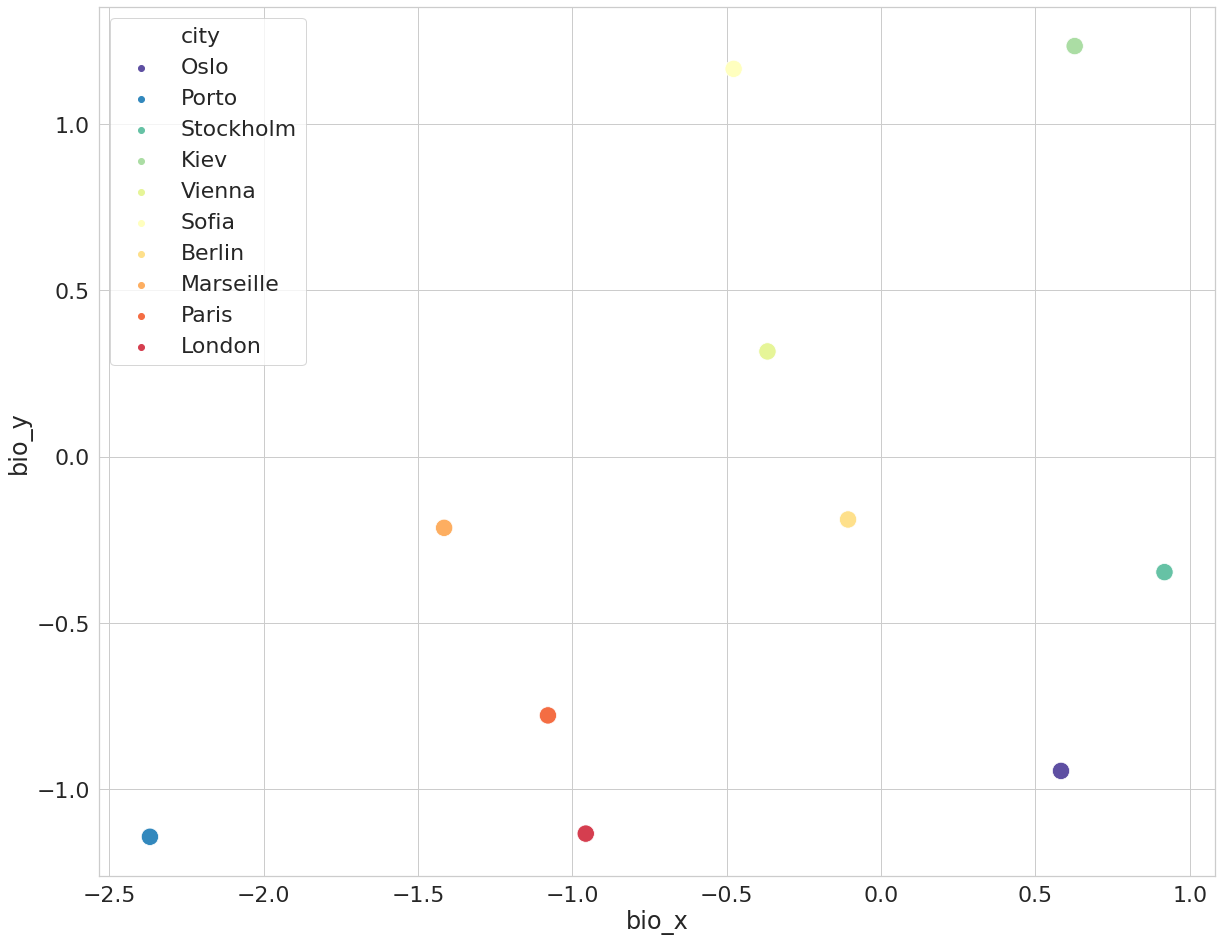

In [7]:
plt.figure(figsize=(20,16))
sns.set(style="whitegrid",font_scale=2)
sns.scatterplot(x='bio_x',y='bio_y',data=tmp,palette=Spectral11[:10],hue='city',s=300)
plt.savefig('../img/10city_BIOplot.pdf')

## before binning tsne

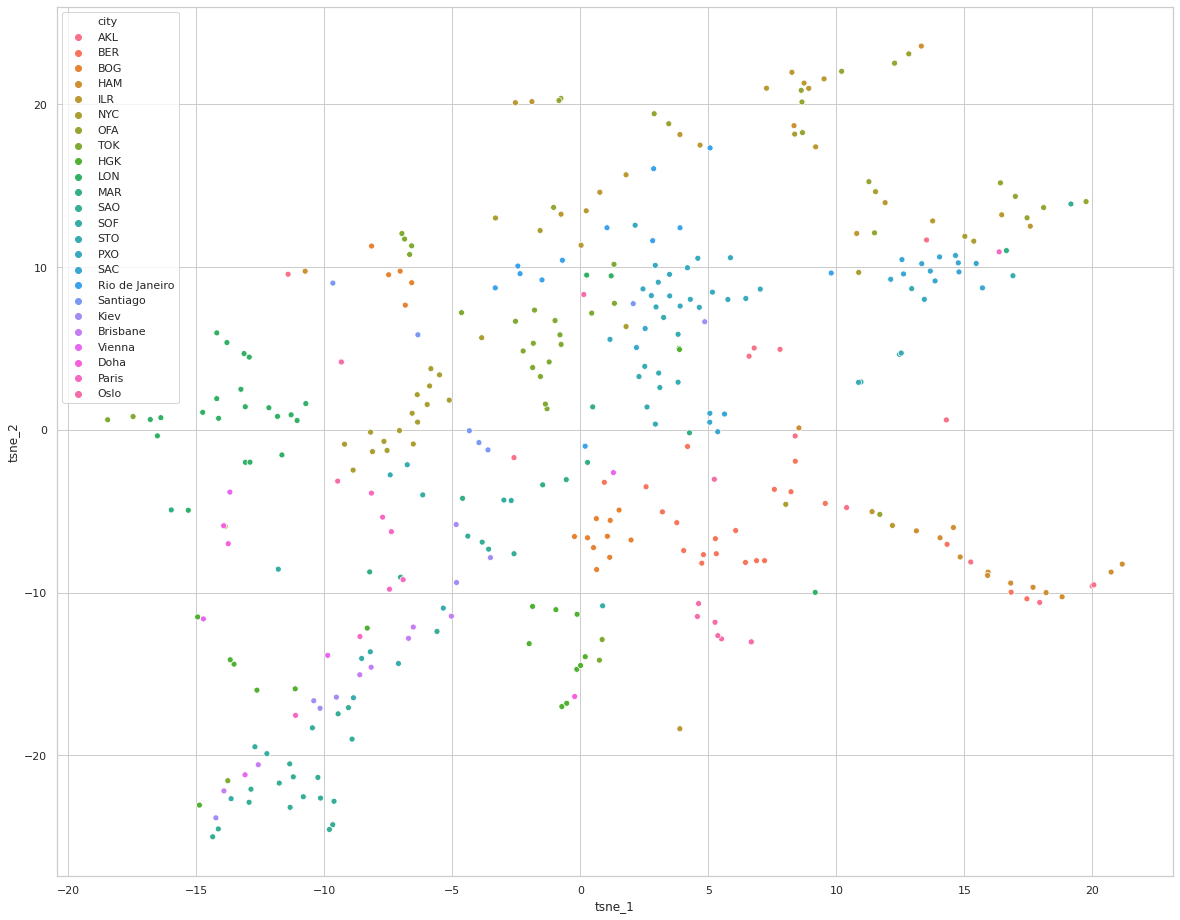

In [135]:
from sklearn.manifold import TSNE

def tsne_scatter(data,feature,traget,draw=False):
    """
    input:
        data: data is a dataframe with sample index and feature is a list
        feature: feature is list of key dimension that you fit into embedded space
        traget: str, traget information with sample id index
    return:
        scatterplot
    e.g.
        tsne_scatter(data,[feature1,feature2,feature3],traget)
    """
    assert len(feature)>2
    X_tsne = TSNE(n_components=2,
                  learning_rate=30,
                  random_state=np.random.seed(10),
                  metric='euclidean').fit_transform(data[feature].values)
    sample_tsne = pd.DataFrame(index=data.index,columns=['tsne_1','tsne_2'],data=X_tsne)
    
    tsne_data = pd.merge(data[[traget]],sample_tsne,right_index=True,left_index=True)
    if draw:
        plt.figure(figsize=(13,9))
        ax = sns.scatterplot(x="tsne_1", y="tsne_2", hue=traget,data=tsne_data)
    return tsne_data


all_sample = pd.read_csv('../data/{}/train_data.csv'.format(tag),index_col=0).T
all_feature = list(all_sample.columns)
all_sample_label = [i.split('_')[3].split('-')[0] for i in all_sample.index]
all_sample['city'] = all_sample_label
# test data
expand_sample = pd.read_csv('../data/{}/test_data.csv'.format(tag),index_col=0).T
expand_feature = list(expand_sample.columns)

expand_sample = pd.merge(pd.read_csv('../data/test_true_label.csv',index_col=1),
                         expand_sample,
                         left_index=True,
                         right_index=True)

all_sample = pd.concat([all_sample,expand_sample])
all_data_label = all_sample['city'].copy()

# Binning in all train set
all_sample['city'] = all_data_label

con_tsne_data = tsne_scatter(all_sample,key,'city')
plt.figure(figsize=(20,16))
sns.set(style="whitegrid",font_scale=1)
sns.scatterplot(x='tsne_1',y='tsne_2',data=con_tsne_data,hue='city')
plt.savefig('../img/woBinning_tsne_plot_kraken_feature.pdf')

## binning tsne

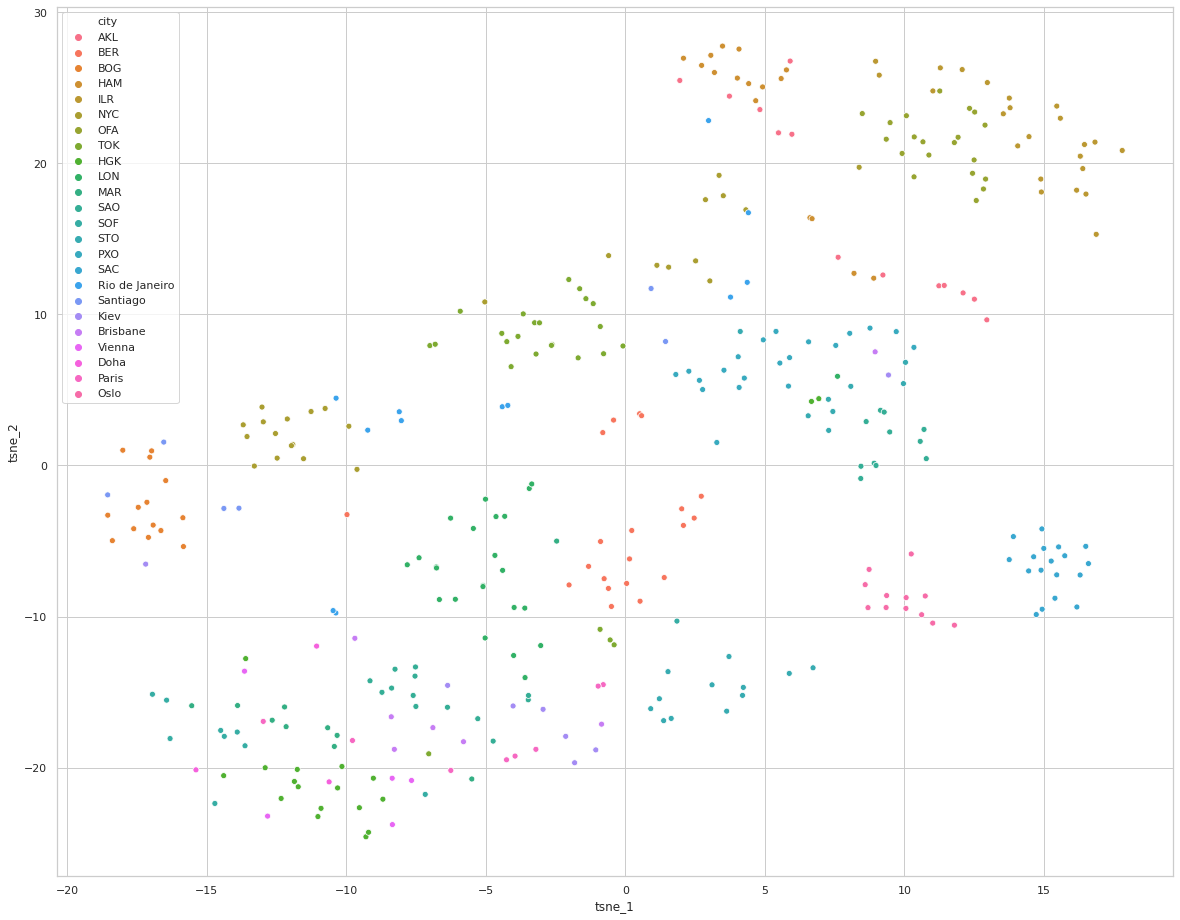

In [136]:
all_sample = pd.read_csv('../data/{}/train_data.csv'.format(tag),index_col=0).T
all_feature = list(all_sample.columns)
all_sample_label = [i.split('_')[3].split('-')[0] for i in all_sample.index]
all_sample['city'] = all_sample_label
# test data
expand_sample = pd.read_csv('../data/{}/test_data.csv'.format(tag),index_col=0).T
expand_feature = list(expand_sample.columns)

expand_sample = pd.merge(pd.read_csv('../data/test_true_label.csv',index_col=1),
                         expand_sample,
                         left_index=True,
                         right_index=True)

all_sample = pd.concat([all_sample,expand_sample])
all_data_label = all_sample['city'].copy()

# Binning in all train set
all_sample = binning_data(all_sample[all_feature])
all_sample['city'] = all_data_label

all_sample['city'] = all_data_label

con_tsne_data = tsne_scatter(all_sample,key,'city')
plt.figure(figsize=(20,16))
sns.set(style="whitegrid",font_scale=1)
sns.scatterplot(x='tsne_1',y='tsne_2',data=con_tsne_data,hue='city')
plt.savefig('../img/binning_tsne_plot_kraken_feature.pdf')

In [94]:
data = pd.concat([pd.read_table('../data/kraken_report_20200811/{}'.format(i),header=None)[[3,5]] for i in os.listdir('../data/kraken_report_20200811/') if 'report' in i]).drop_duplicates()
data = data[data[5].isin(all_feature)]
data['levels'] = [i[0] for i in data[3]]
level_data = data.groupby('levels').count()[[3]]
level_data = level_data.rename(columns={3:'original features'})
level_data = pd.merge(level_data,
                      data[data[5].isin(key)].groupby('levels').count()[[3]].rename(columns={3:'extracted features'}),
                      how='outer',left_index=True,right_index=True).fillna(0)
level_data = level_data.reset_index()

In [98]:
level_data

,levels,original features,extracted features
0,C,73,0.0
1,D,20,0.0
2,F,344,2.0
3,G,913,6.0
4,K,4,0.0
5,O,160,1.0
6,P,48,0.0
7,R,3,0.0
8,S,3961,41.0
9,U,1,0.0


In [100]:
level_data = pd.melt(level_data,id_vars='levels')

In [477]:
level_data.to_csv('../level_data.csv')

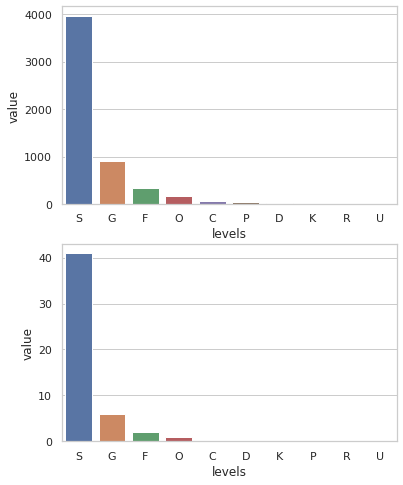

In [124]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False,figsize=(6,8))

sns.barplot(x='levels',y='value',ax=ax1,data=level_data[level_data.variable=='original features'].sort_values('value',ascending=False))
sns.barplot(x='levels',y='value',ax=ax2,data=level_data[level_data.variable=='extracted features'].sort_values('value',ascending=False))

plt.savefig('../img/kraken_feature_level.pdf',dpi=300)

Fig. 5. The total number of raw feature is 5527, including ...

In [137]:
pd.read_csv('../kriging_result/kraken_data/STO-001.csv')

,city_ascii,GEOprob,BIOprob,x,y,bio_x,bio_y
0,Vaduz,0.277938,0.139506,1.059394e+06,5.963925e+06,-0.845335,-0.130961
1,Klaipeda,0.264239,0.311490,2.351057e+06,7.502955e+06,0.660588,0.162225
2,Vilnius,0.287732,0.435501,2.818231e+06,7.300661e+06,0.778297,0.552728
3,Siauliai,0.267674,0.373796,2.596527e+06,7.546202e+06,0.806564,0.311360
4,Kaunas,0.273243,0.391847,2.658309e+06,7.352246e+06,0.728066,0.425673
...,...,...,...,...,...,...,...
724,Taranto,0.243372,0.094813,1.918035e+06,4.940099e+06,-0.995803,0.831150
725,Brindisi,0.231505,0.102595,1.995958e+06,4.959430e+06,-0.946311,0.876392
726,Lecce,0.231470,0.101667,2.020449e+06,4.918454e+06,-0.957227,0.908247
727,Benevento,0.258660,0.086806,1.641962e+06,5.032082e+06,-1.080866,0.610716


In [467]:
city_name = {'BER':'Berlin','LON':'London','MAR':'Marseille',
             'PXO':'Porto','SOF':'Sofia','STO':'Stockholm',
             'Kiev':'Kiev','Oslo':'Oslo','Paris':'Paris','Vienna':'Vienna'}

city_s = {}
for i in city_name.keys():
    city_s[city_name[i]] = i



result = []
for i in os.listdir('../kriging_result/kraken_data/'):
    if 'STO' in i:
        tmp = pd.read_csv('../kriging_result/kraken_data/{}'.format(i))
        tmp = tmp[tmp.city_ascii.isin(city_s.keys())]
        tmp.city_ascii = tmp.city_ascii.replace(city_s)
        tmp = tmp[['city_ascii','BIOprob']].rename(columns={'city_ascii':'city','BIOprob':'{}'.format(i[:-4])})
        result.append(tmp.set_index('city').T)

In [468]:
prob_result = pd.concat(result)
prob_result = prob_result.sort_index()

In [440]:
for C in ['BER', 'LON', 'MAR', 'PXO', 'SOF', 'STO', 'Kiev', 'Oslo', 'Paris', 'Vienna']:
    with open('../random_test/{}/bio_shuffle_{}_result.txt'.format(tag,C),'r') as f:
        shuffle_result = np.array([eval(i) for i in f.read().split('\n') if i])

    with open('../random_test/{}/bio_true_{}_result.txt'.format(tag,C),'r') as f:
        true_result = np.array([eval(i) for i in f.read().split('\n')[:1] if i])

    result = []
    for i in range(true_result.shape[-1]):
        _,pvalues = ttest_ind(shuffle_result[...,i],list(true_result[...,i])*1000)

        if true_result[...,i].mean()-shuffle_result[...,i].mean()<0:
            pvalues =1-0.5*pvalues
        else:
            pvalues =0.5*pvalues
        result.append(pvalues)
    pvalue_result = pd.DataFrame(index=['{}_{}'.format(C,i) for i in range(len(result))],data=result)
    pvalue_result.to_csv('../{}_P_value.csv'.format(C))

---

In [ ]:
all_sample = pd.read_csv('../data/{}/train_data.csv'.format(tag),index_col=0).T
all_feature = list(all_sample.columns)
all_sample_label = [i.split('_')[3].split('-')[0] for i in all_sample.index]
all_sample['city'] = all_sample_label
# test data
expand_sample = pd.read_csv('../data/{}/test_data.csv'.format(tag),index_col=0).T
expand_feature = list(expand_sample.columns)

expand_sample = pd.merge(pd.read_csv('../data/test_true_label.csv',index_col=1),
                         expand_sample,
                         left_index=True,
                         right_index=True)

all_sample = pd.concat([all_sample,expand_sample])
all_data_label = all_sample['city'].copy()

# Binning in all train set
all_sample = binning_data(all_sample[all_feature])
all_sample['city'] = all_data_label

all_sample['city'] = all_data_label
pca_data = pca_scatter(all_sample[all_sample.city.isin(['BER', 'LON', 'MAR', 'PXO', 'SOF', 'STO', 
                                                         'Kiev', 'Oslo', 'Paris', 'Vienna'])],
                        key,
                        'city')

In [ ]:
pca_data['sty'] = [['o',['t','x'][i in good_samp]]['STO' in i] for i in pca_data.index]

In [ ]:
STO_P = pd.read_csv('../STO_P_value.csv',index_col=0)

In [ ]:
good_samp = ['CAMDA19_MetaSUB_csd17_STO-001','CAMDA19_MetaSUB_csd17_STO-002','CAMDA1a9_MetaSUB_csd17_STO-003',
            'CAMDA19_MetaSUB_csd17_STO-004','CAMDA19_MetaSUB_csd17_STO-005','CAMDA19_MetaSUB_csd17_STO-008',
            'CAMDA19_MetaSUB_csd17_STO-009','CAMDA19_MetaSUB_csd17_STO-011','CAMDA19_MetaSUB_csd17_STO-013',
            'CAMDA19_MetaSUB_csd17_STO-014','CAMDA19_MetaSUB_csd17_STO-016','CAMDA19_MetaSUB_csd17_STO-020']

In [ ]:
plt.figure(figsize=(15,12))
sns.set(style="whitegrid",font_scale=1)
sns.scatterplot(x='pc_1',y='pc_2',data=pca_data,hue='city',style='sty',s=150)
for sample_name, _,x,y,_ in pca_data[pca_data.city=='STO'].reset_index().values:
        plt.text(x+0.05, y+0.05, sample_name.split('_')[-1], fontsize=7)

In [469]:
tmp = europe[europe.city.isin(['Oslo','Porto','Stockholm','Kiev','Vienna',
                               'Sofia','Berlin','Marseille','Paris', 'London'])].copy()
prob_result = pd.merge(prob_result.rename(columns=city_name).T,tmp[['city','bio_x','bio_y']],left_index=True,right_on='city')

In [471]:
prob_result

,STO-001,STO-002,STO-003,STO-004,STO-005,STO-006,STO-007,STO-008,STO-009,STO-010,...,STO-014,STO-015,STO-016,STO-017,STO-018,STO-019,STO-020,city,bio_x,bio_y
1427,0.010940,0.010782,0.009605,0.022465,0.017918,0.014723,0.015492,0.012118,0.112220,0.066263,...,0.102372,0.074178,0.013440,0.010241,0.019741,0.005170,0.007660,Oslo,0.582610,-0.944524
1866,0.007345,0.604740,0.176979,0.009788,0.230957,0.276216,0.017603,0.491506,0.025913,0.071226,...,0.101232,0.026869,0.267790,0.089051,0.001741,0.170282,0.010145,Porto,-2.368739,-1.142533
2794,0.120376,0.173406,0.156389,0.123854,0.332925,0.094249,0.118297,0.138009,0.417513,0.117278,...,0.124425,0.116862,0.329441,0.117802,0.059419,0.094576,0.121733,Stockholm,0.917824,-0.346895
3556,0.497906,0.306934,0.634799,0.106142,0.657023,0.492823,0.490678,0.354946,0.735313,0.338363,...,0.252469,0.461483,0.632938,0.348840,0.192787,0.207469,0.338815,Kiev,0.626921,1.234615
4250,0.019274,0.003038,0.002509,0.149402,0.029337,0.165577,0.010475,0.090743,0.011621,0.016832,...,0.002613,0.022065,0.023351,0.003260,0.217306,0.419741,0.056585,Vienna,-0.368290,0.316595
4633,0.003315,0.006888,0.001581,0.027371,0.017195,0.022334,0.002941,0.019115,0.027031,0.066605,...,0.013019,0.030909,0.012244,0.020149,0.076341,0.032364,0.006386,Sofia,-0.477867,1.166185
6302,0.003189,0.013329,0.007184,0.072621,0.007734,0.009496,0.007898,0.017101,0.036460,0.039718,...,0.086532,0.057025,0.006144,0.065885,0.431752,0.157810,0.033944,Berlin,-0.107210,-0.188661
6731,0.029008,0.014504,0.027257,0.128817,0.002169,0.002283,0.021589,0.002084,0.005018,0.111049,...,0.200289,0.013309,0.005839,0.082659,0.032548,0.002329,0.063884,Marseille,-1.415697,-0.213738
6735,0.417171,0.029949,0.121125,0.398229,0.027664,0.011902,0.408330,0.005900,0.019383,0.235897,...,0.187370,0.294065,0.029622,0.352836,0.009569,0.002678,0.446847,Paris,-1.079396,-0.777669
6959,0.011852,0.009838,0.018961,0.085166,0.010003,0.004646,0.024994,0.006488,0.027042,0.054046,...,0.054106,0.020097,0.008632,0.027079,0.018215,0.002158,0.035734,London,-0.956924,-1.133022


In [472]:
prob_result = prob_result.reset_index(drop=True)

In [473]:
prob_result

,STO-001,STO-002,STO-003,STO-004,STO-005,STO-006,STO-007,STO-008,STO-009,STO-010,...,STO-014,STO-015,STO-016,STO-017,STO-018,STO-019,STO-020,city,bio_x,bio_y
0,0.010940,0.010782,0.009605,0.022465,0.017918,0.014723,0.015492,0.012118,0.112220,0.066263,...,0.102372,0.074178,0.013440,0.010241,0.019741,0.005170,0.007660,Oslo,0.582610,-0.944524
1,0.007345,0.604740,0.176979,0.009788,0.230957,0.276216,0.017603,0.491506,0.025913,0.071226,...,0.101232,0.026869,0.267790,0.089051,0.001741,0.170282,0.010145,Porto,-2.368739,-1.142533
2,0.120376,0.173406,0.156389,0.123854,0.332925,0.094249,0.118297,0.138009,0.417513,0.117278,...,0.124425,0.116862,0.329441,0.117802,0.059419,0.094576,0.121733,Stockholm,0.917824,-0.346895
3,0.497906,0.306934,0.634799,0.106142,0.657023,0.492823,0.490678,0.354946,0.735313,0.338363,...,0.252469,0.461483,0.632938,0.348840,0.192787,0.207469,0.338815,Kiev,0.626921,1.234615
4,0.019274,0.003038,0.002509,0.149402,0.029337,0.165577,0.010475,0.090743,0.011621,0.016832,...,0.002613,0.022065,0.023351,0.003260,0.217306,0.419741,0.056585,Vienna,-0.368290,0.316595
5,0.003315,0.006888,0.001581,0.027371,0.017195,0.022334,0.002941,0.019115,0.027031,0.066605,...,0.013019,0.030909,0.012244,0.020149,0.076341,0.032364,0.006386,Sofia,-0.477867,1.166185
6,0.003189,0.013329,0.007184,0.072621,0.007734,0.009496,0.007898,0.017101,0.036460,0.039718,...,0.086532,0.057025,0.006144,0.065885,0.431752,0.157810,0.033944,Berlin,-0.107210,-0.188661
7,0.029008,0.014504,0.027257,0.128817,0.002169,0.002283,0.021589,0.002084,0.005018,0.111049,...,0.200289,0.013309,0.005839,0.082659,0.032548,0.002329,0.063884,Marseille,-1.415697,-0.213738
8,0.417171,0.029949,0.121125,0.398229,0.027664,0.011902,0.408330,0.005900,0.019383,0.235897,...,0.187370,0.294065,0.029622,0.352836,0.009569,0.002678,0.446847,Paris,-1.079396,-0.777669
9,0.011852,0.009838,0.018961,0.085166,0.010003,0.004646,0.024994,0.006488,0.027042,0.054046,...,0.054106,0.020097,0.008632,0.027079,0.018215,0.002158,0.035734,London,-0.956924,-1.133022


In [474]:
prob_result['color'] = Spectral11[:10]

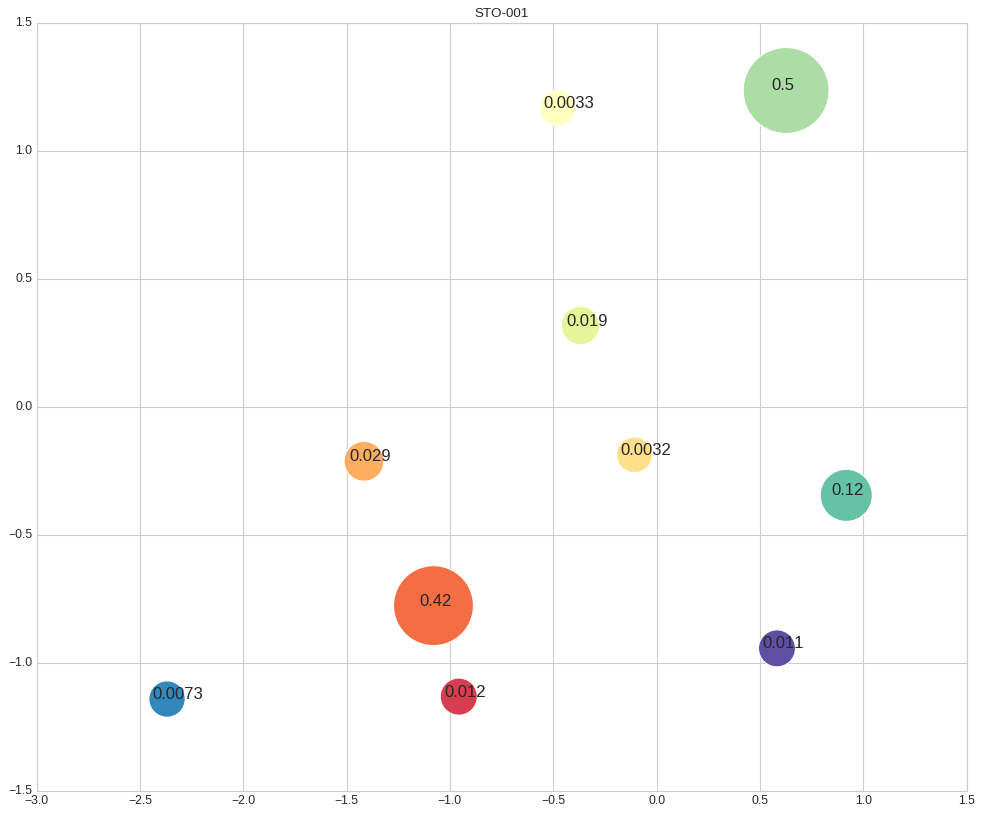

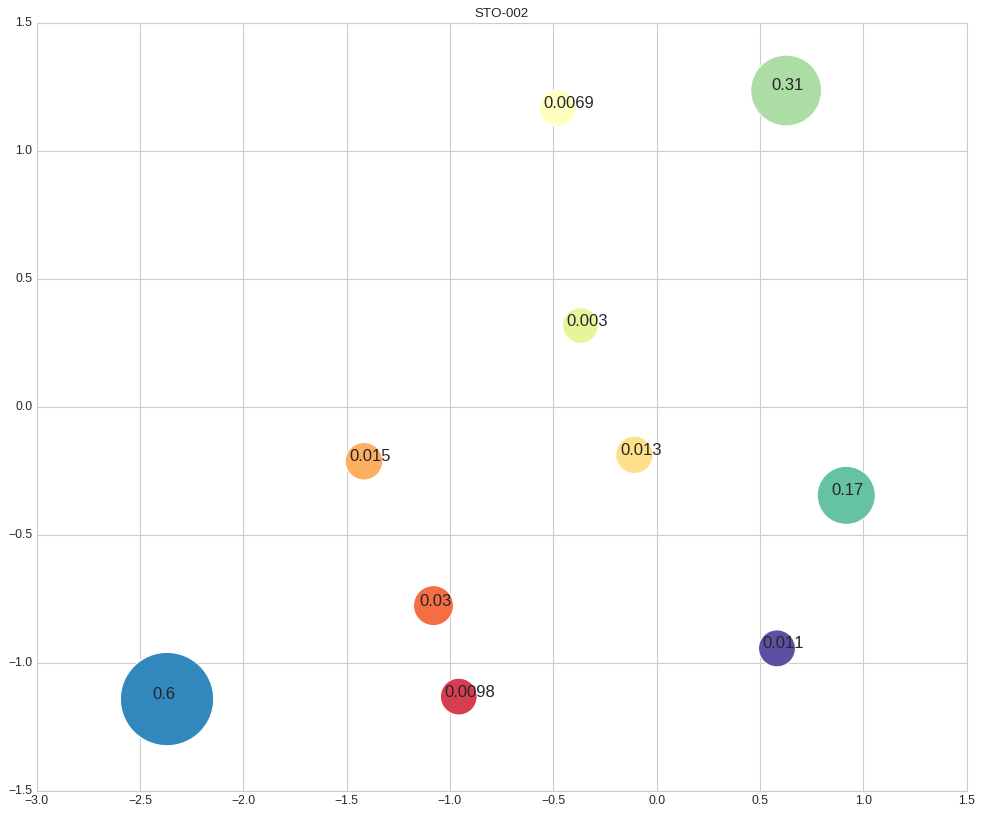

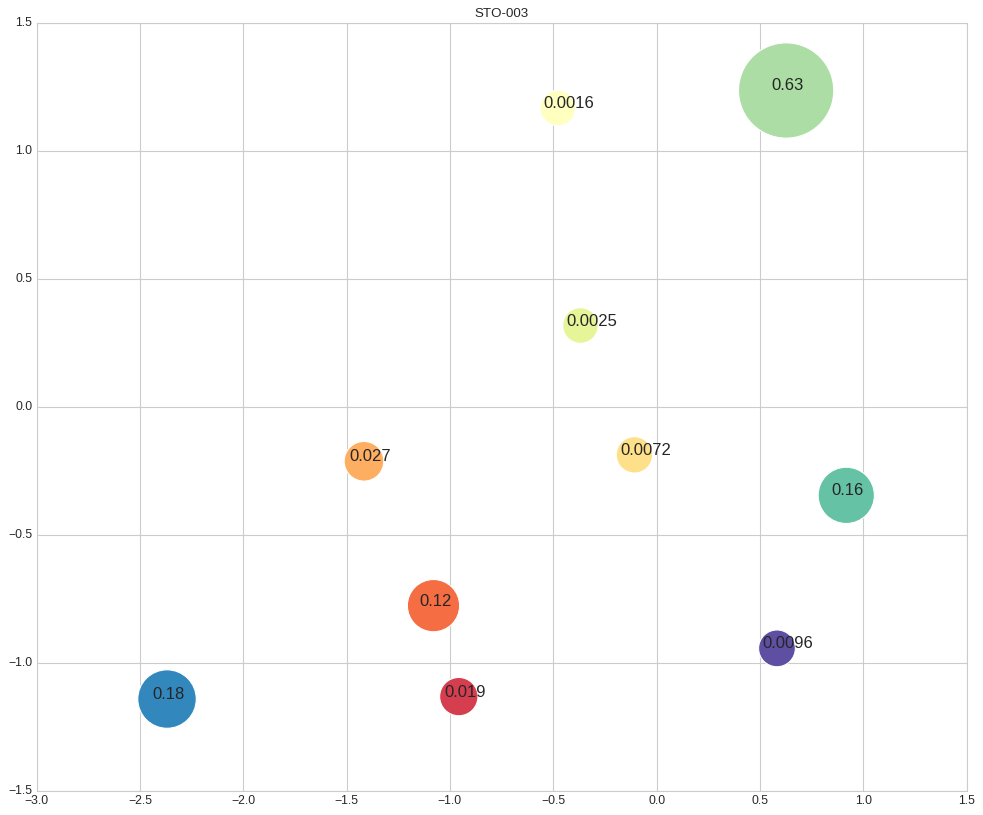

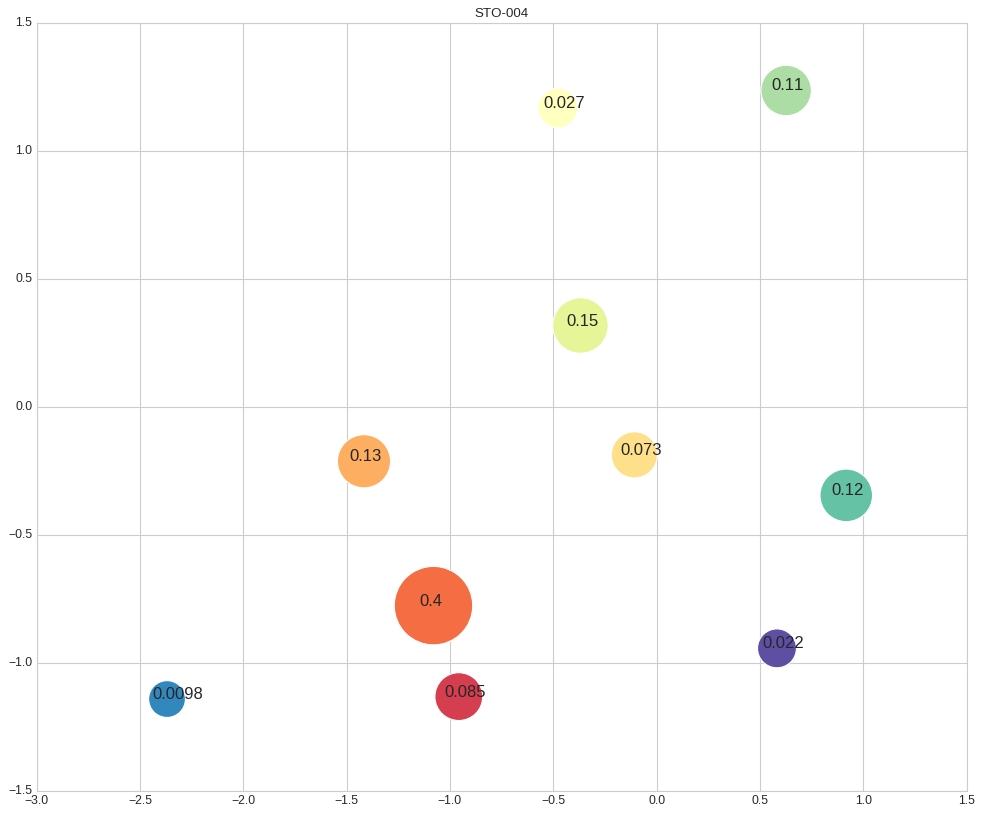

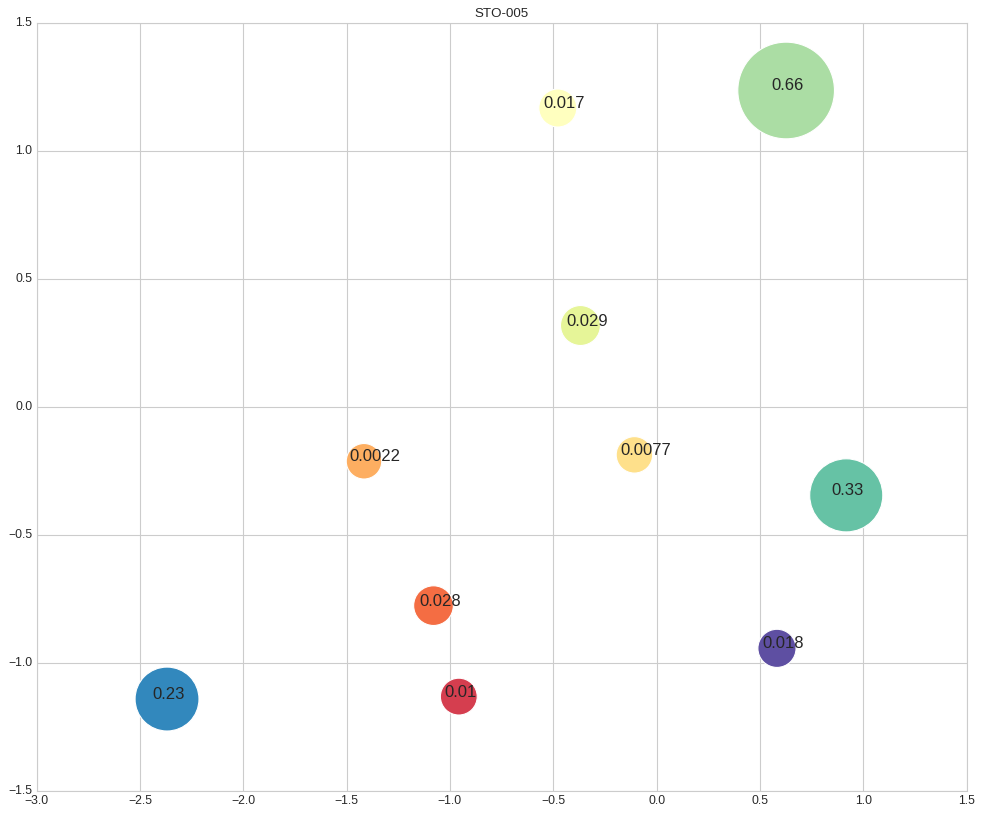

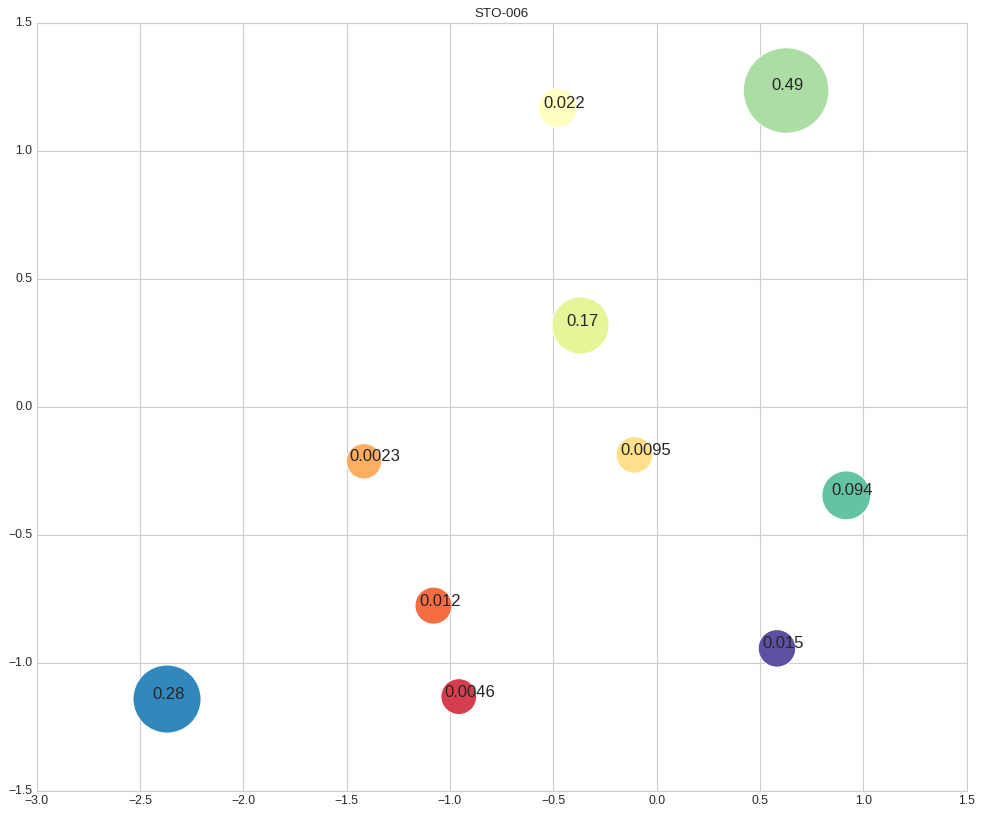

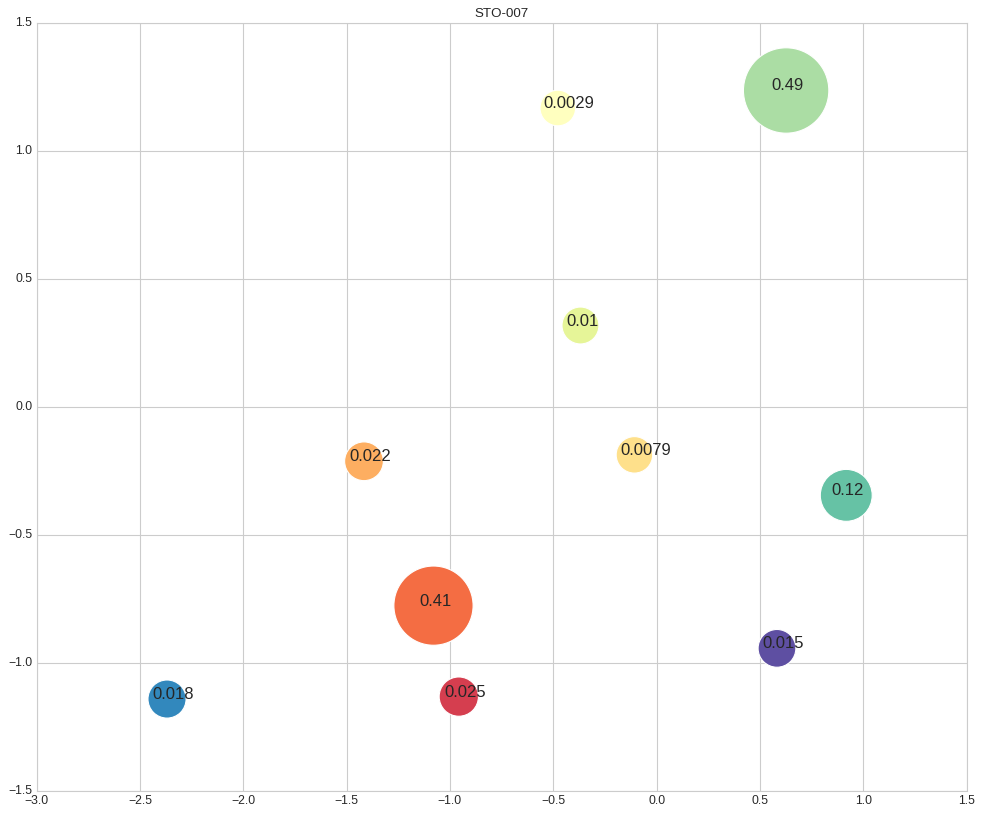

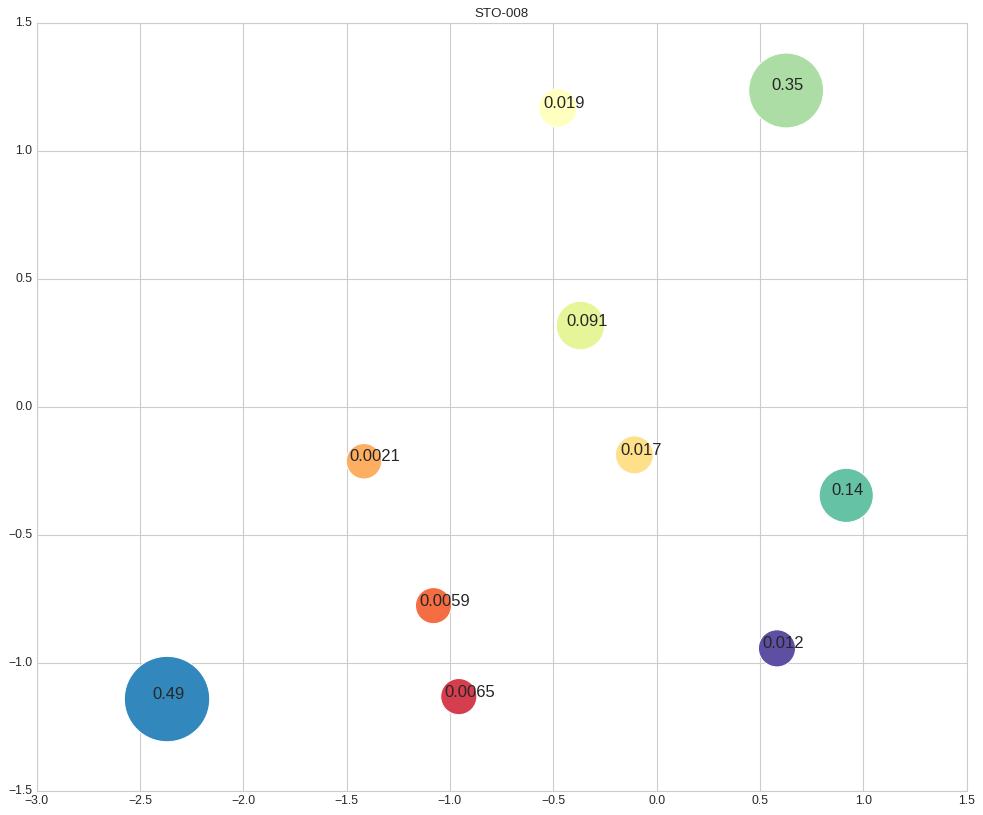

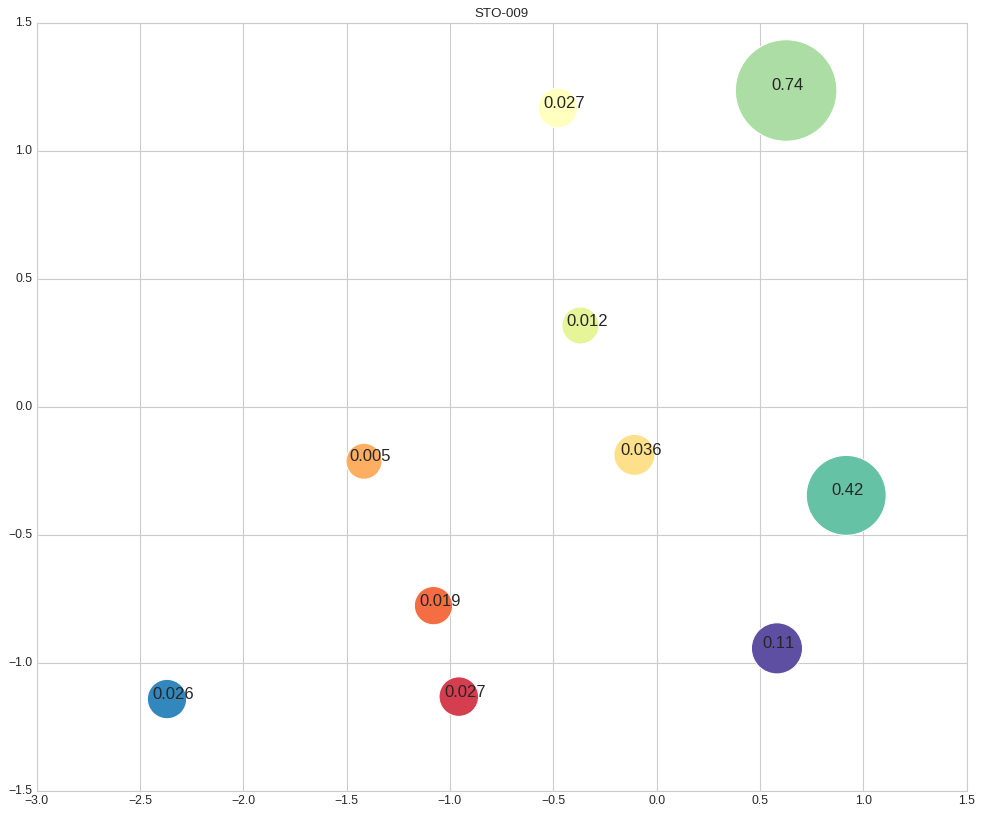

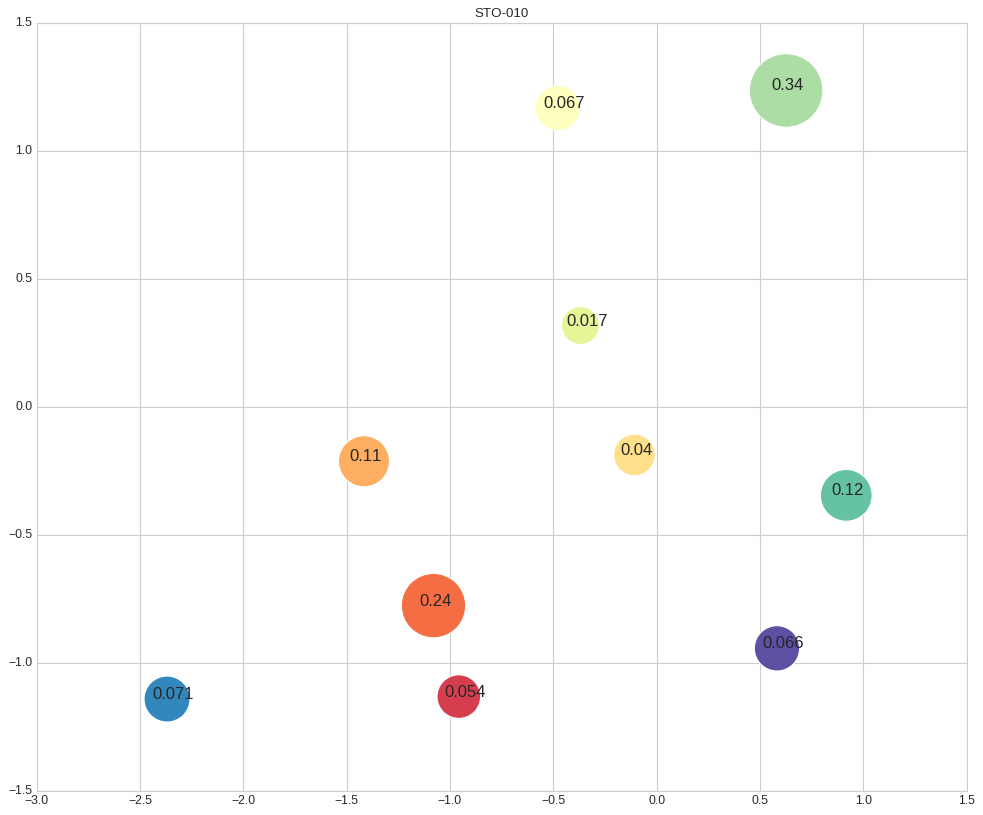

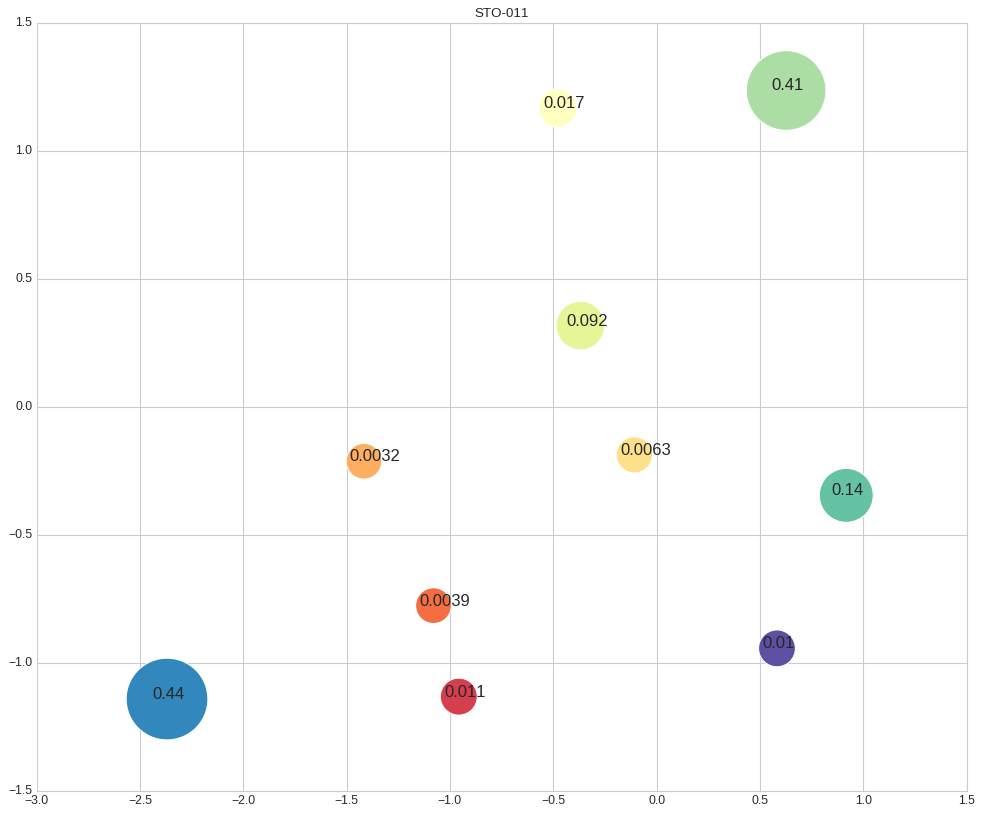

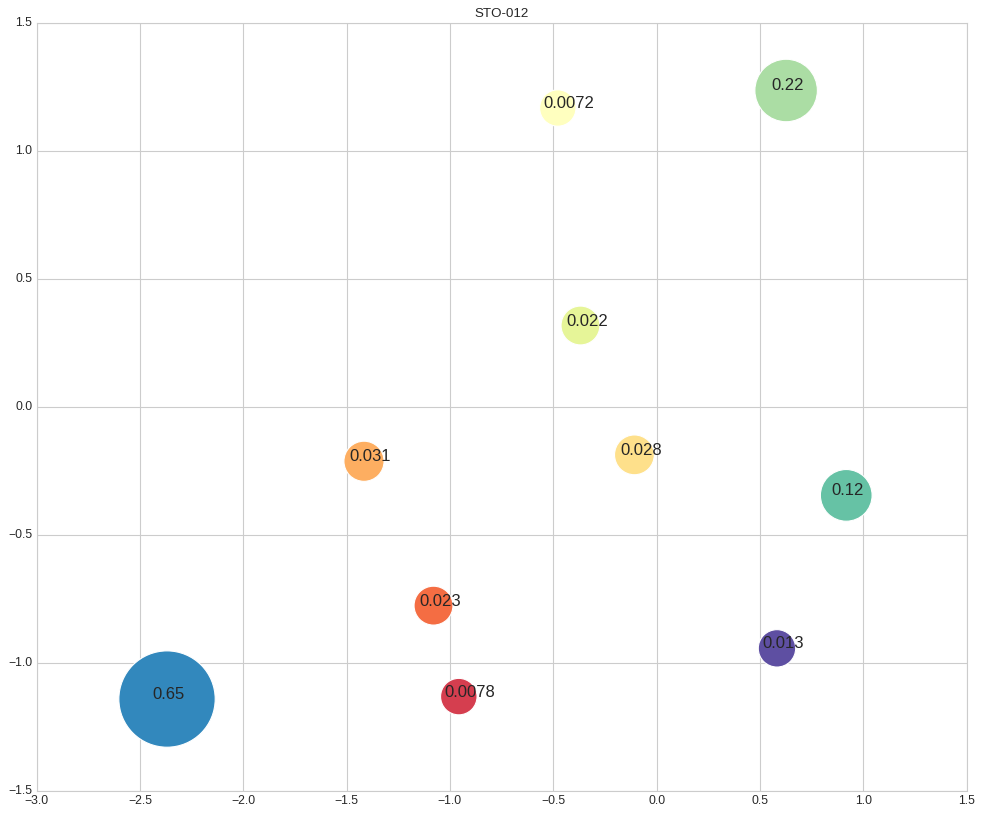

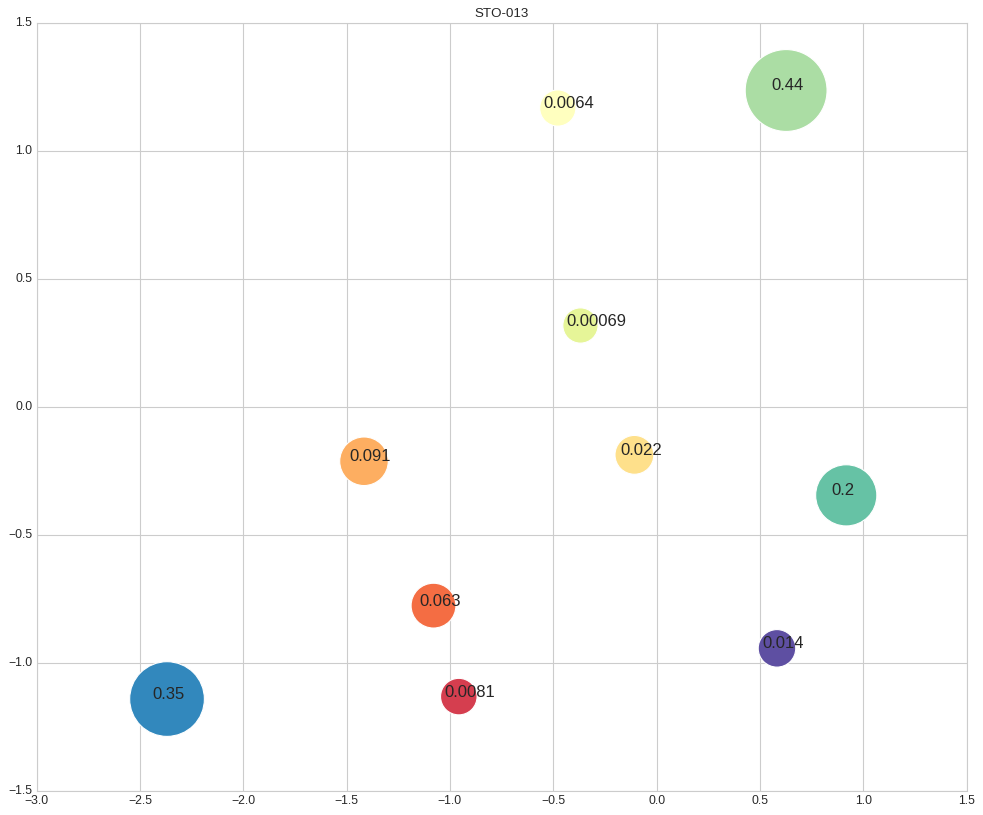

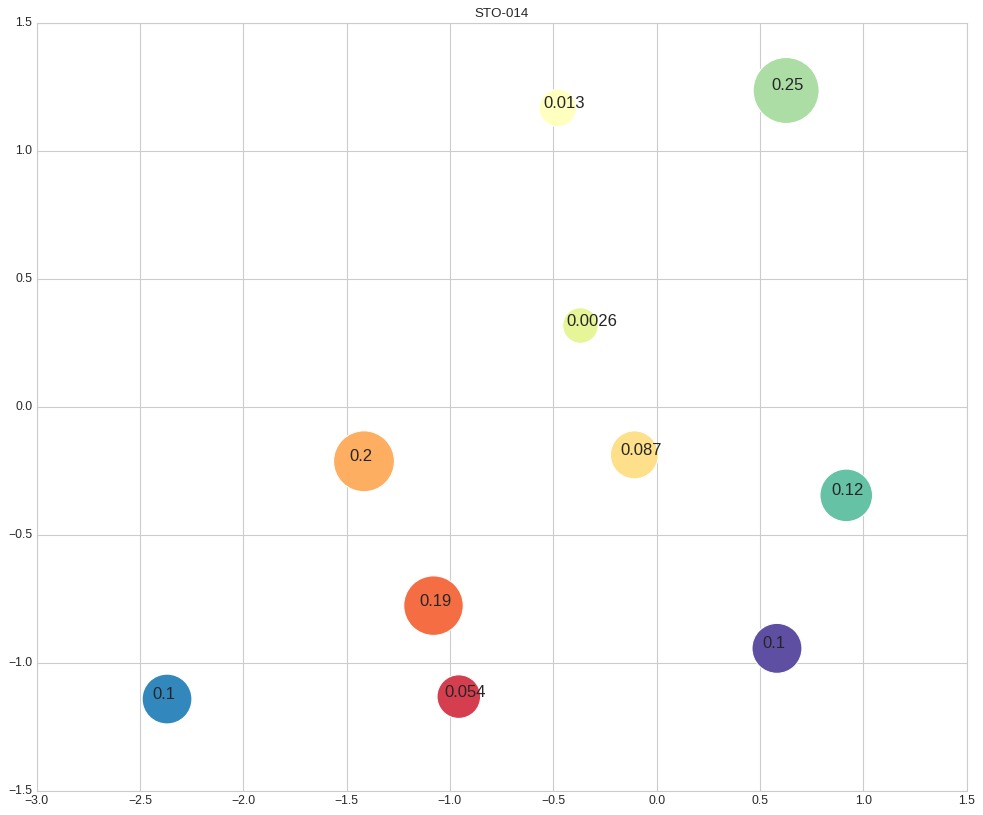

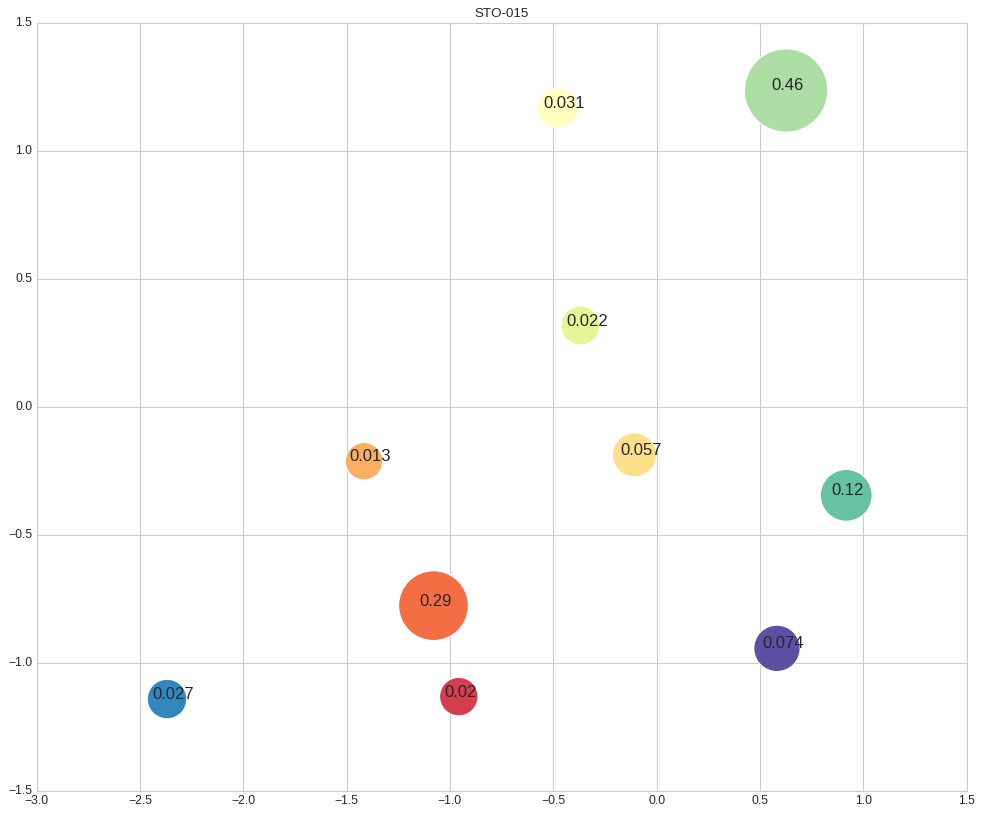

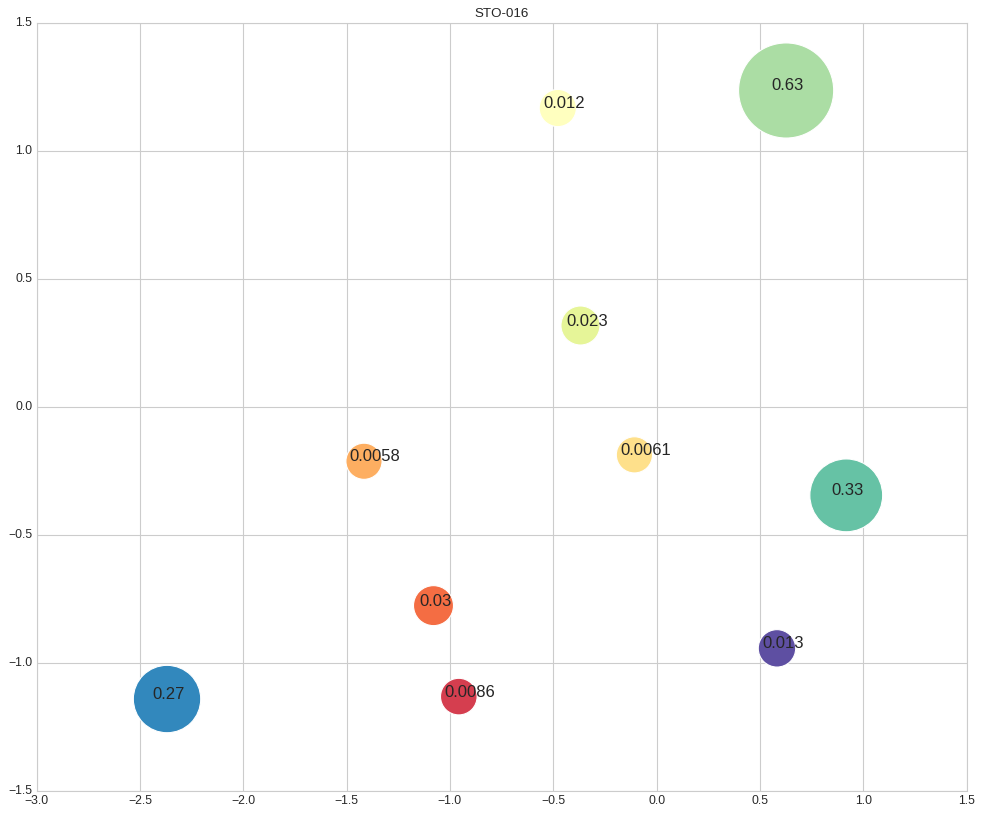

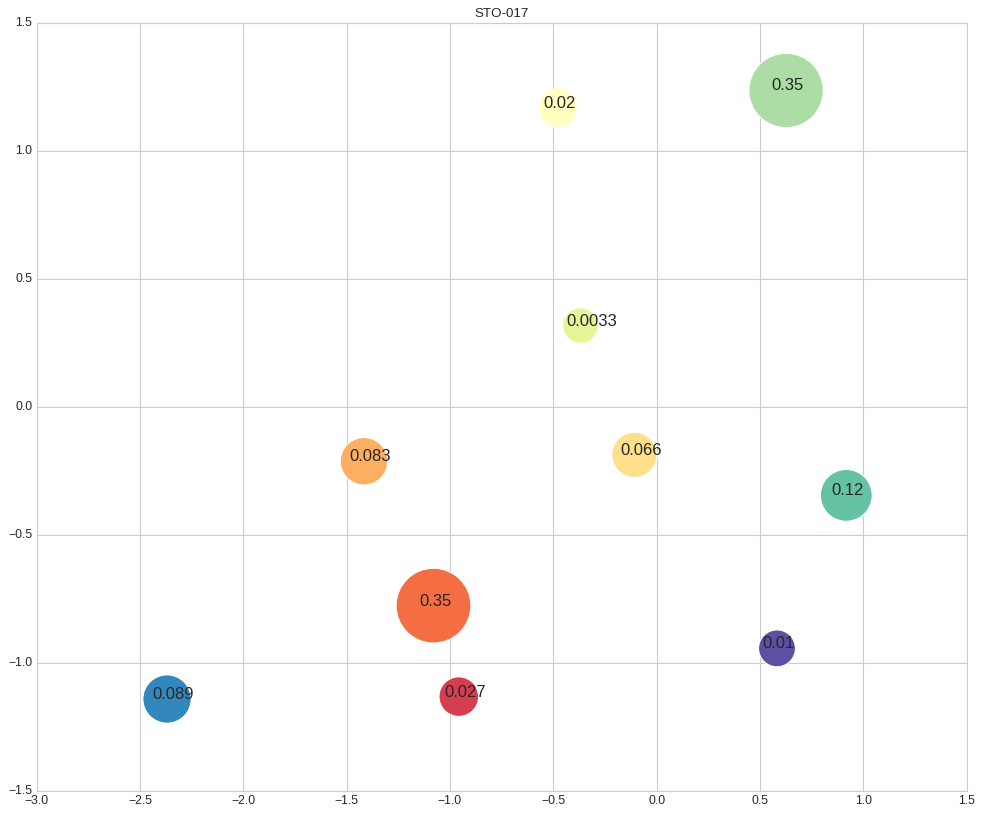

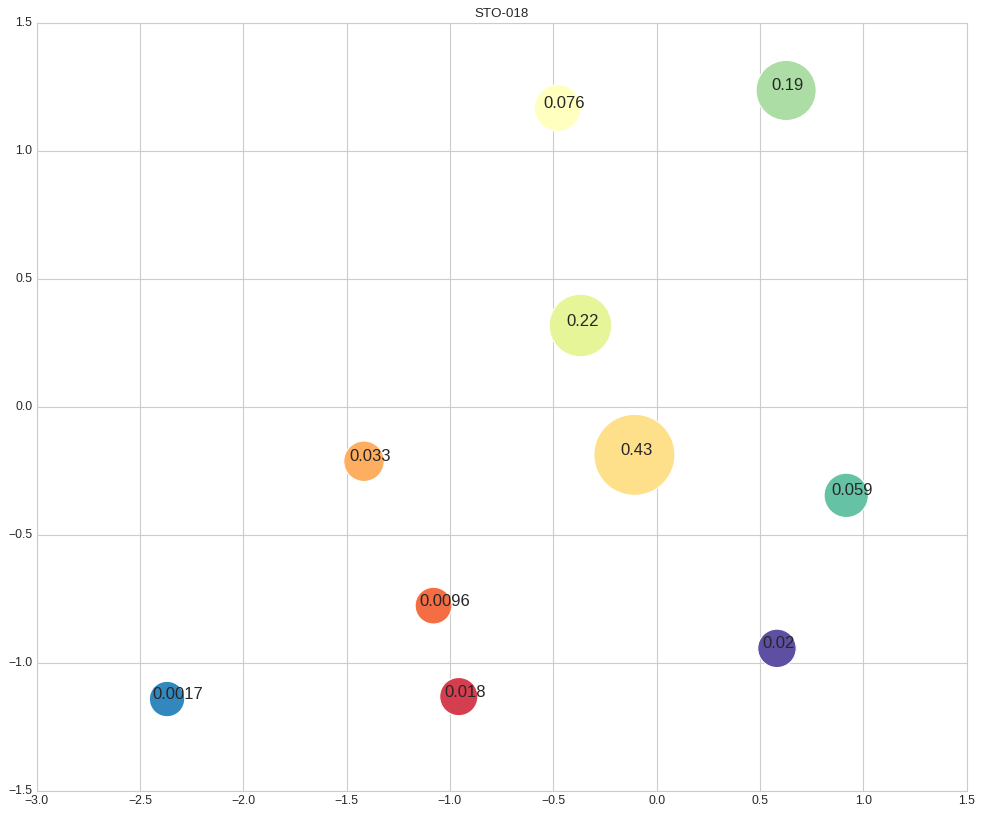

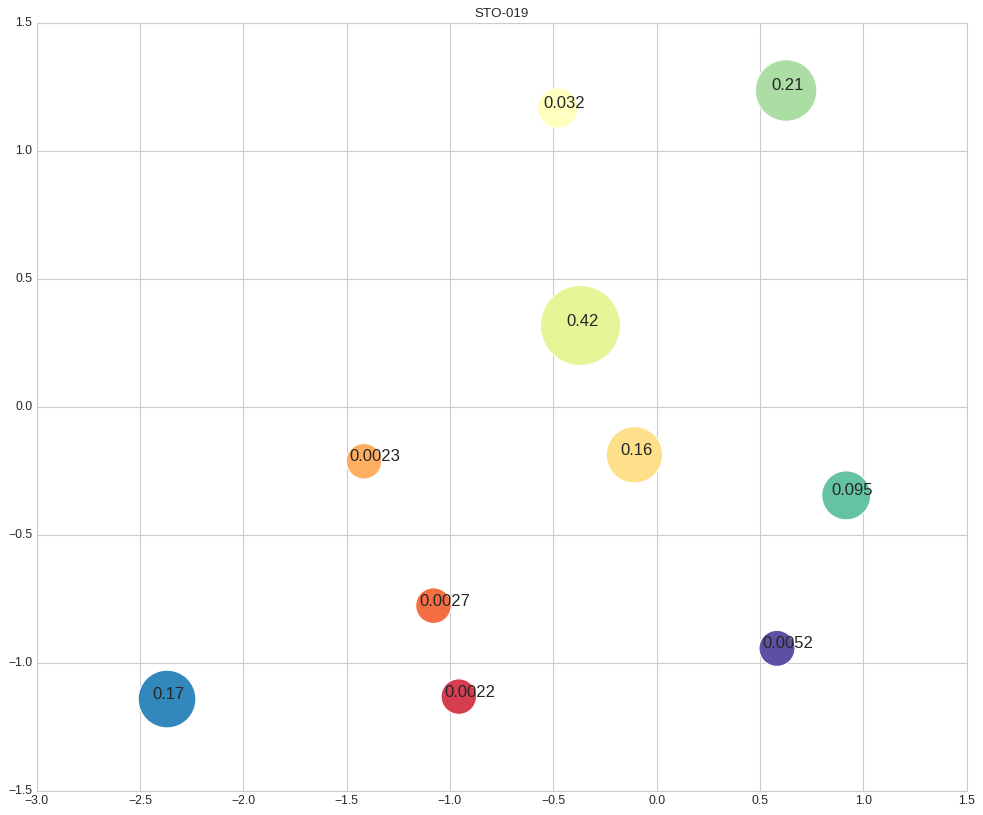

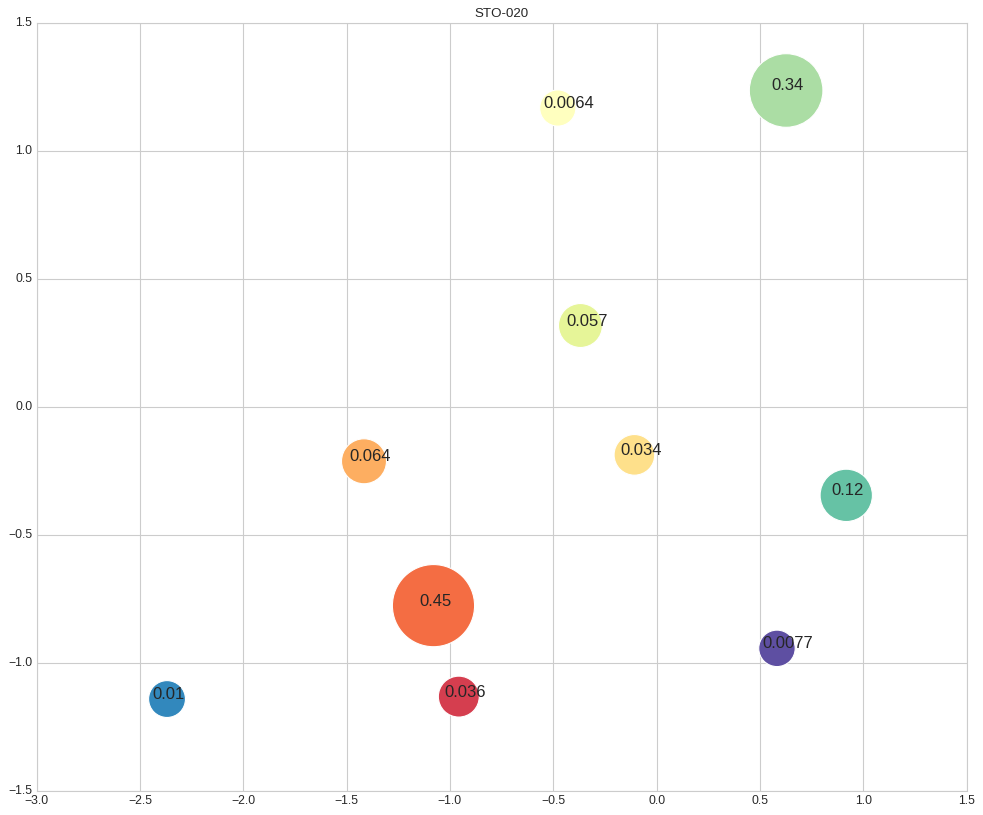

In [475]:
for sample in prob_result.columns:
    if 'STO' not in sample:continue
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(15,12))
    x_values = prob_result['bio_x'].values
    y_values = prob_result['bio_y'].values
    s = (prob_result[sample].values+0.1)*10000
    n = list(prob_result[sample].values)
    c = prob_result['color']
    ax = plt.scatter(x_values, y_values, s,c=c)
    
    for i, txt in enumerate(n):
        plt.text(x_values[i]-0.07, y_values[i], '{:.2}'.format(txt), fontsize=15)
    plt.title(sample)
    plt.savefig('../img/{}_sample_prob_result.pdf'.format(sample))

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix


tag = 'kraken_data'
train_data = pd.read_csv("../data/{}/train_data.csv".format(tag), index_col=0)
train_data = train_data[train_data.index!='unclassified']
# load test data
test_data = pd.read_csv('../data/{}/test_data.csv'.format(tag), index_col=0)
# binning data
all_data = pd.merge(train_data, test_data, left_index=True, right_index=True)
all_data = binning_data(all_data.T)

key = pd.read_table('../feature_extration_result/feature_list_{}.txt'.format(tag),header=None)[0].tolist()
train_data = all_data.loc[train_data.columns]
test_data = all_data.loc[test_data.columns]

# extracted city label from sample name
label = pd.DataFrame(
    index=train_data.index,
    columns=["city"],
    data=[i.split("_")[3].split("-")[0] for i in train_data.index])

label = label.reset_index()
label = label.rename(columns={"index": "sample"})

tmp = pd.merge(label, train_data, left_on="sample", right_index=True)
cf_m = np.zeros([len(np.unique(y)),len(np.unique(y))])
x, y = tmp[key].values, tmp["city"].values     
name = list(set(y))

n = 1000  # Number of re-shuffling & splitting iterations
# Stratified ShuffleSplit cross-validator
sp = StratifiedShuffleSplit(n_splits=n, test_size=0.3, random_state=0)
acc_list = []
acc = 0
for train_sample, test_sample in sp.split(x, y):
    
    clf = LogisticRegression(penalty="l2", 
                             C=0.6,
                             multi_class="ovr",
                             solver='liblinear', 
                             class_weight="balanced")
#         clf = RandomForestClassifier()
#         clf = XGBClassifier()
#         clf = KNeighborsClassifier()
    X_train, y_train = tmp[key].iloc[train_sample].values, tmp['city'].iloc[train_sample].values
    clf.fit(X_train, y_train)
    X_test, y_test = tmp[key].iloc[test_sample].values, tmp['city'].iloc[test_sample].values
    cf_m += confusion_matrix(clf.predict(X_test),y_test,labels=name)

cf_m = cf_m/n
cf_m = pd.DataFrame(index=name,columns=name,data=cf_m)

In [36]:
cf_m.shape

(16, 16)

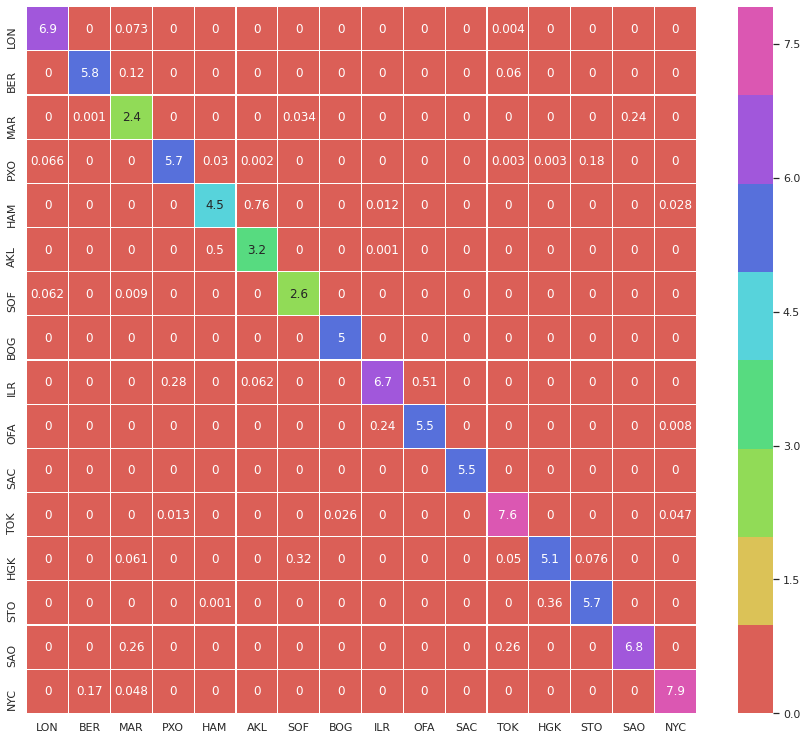

In [45]:
plt.figure(figsize=(15,13))
sns.heatmap(cf_m,annot=True,cmap=sns.color_palette("hls", 8),linewidths=0.2)
# plt.savefig('../img/confusion_matrix.pdf')

In [526]:
performance = pd.read_table('../classifier_performance.txt',header=None)

In [529]:
performance.head()

,0,1
0,lgr,0.869565
1,rdf,0.826087
2,xgb,0.847826
3,knn,0.804348
4,lgr,0.847826


In [528]:
performance.groupby(0).mean()

,1
0,
knn,0.803913
lgr,0.860109
rdf,0.812391
xgb,0.831739
